In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
pip install xgboost


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 544.7 kB/s eta 0:03:04
   ---------------------------------------- 0.3/99.8 MB 2.0 MB/s eta 0:00:51
   ---------------------------------------- 0.4/99.8 MB 2.1 MB/s eta 0:00:48
   ---------------------------------------- 0.6/99.8 MB 2.4 MB/s eta 0:00:42
   ---------------------------------------- 0.8/99.8 MB 3.0 MB/s eta 0:00:34
    --------------------------------------- 1.3/99.8 MB 3.8 MB/s eta 0:00:26
    --------------------------------------- 1.9/99.8 MB 5.0 MB/s eta 0:00:20
   - -------------------------------------- 2.8/99.8 MB 6.7 MB/s eta 0:00:15
   - -------------------------------------- 3.5/99.8 MB 7.5 MB/s eta 0:00:13
   - -------------------------------------- 4.2/99.8 MB 8.1 MB/s eta 0:00:12
   - ------------

In [130]:
df= pd.read_csv("train_sampled.csv")

In [132]:
df['Month_Year'] = pd.to_datetime(df['S_2']).dt.to_period('M')

customer_month_counts = df.groupby('customer_ID')['Month_Year'].nunique().reset_index(name='Months_Count')

customer_count_by_months = customer_month_counts.groupby('Months_Count').size().reset_index(name='Customer_Count')

df.pop('Month_Year')

print(customer_count_by_months)

    Months_Count  Customer_Count
0              1            1005
1              2            1264
2              3            1145
3              4             940
4              5             950
5              6            1093
6              7            1038
7              8            1217
8              9            1208
9             10            1329
10            11            1203
11            12            2082
12            13           77309


In [135]:
df['Month_Year'] = pd.to_datetime(df['S_2']).dt.to_period('M')
customer_month_counts = df.groupby('customer_ID')['Month_Year'].nunique().reset_index(name='Months_Count')
avg_target_by_customer = df.groupby('customer_ID')['target'].mean().reset_index(name='Average_Target')
merged_data = pd.merge(customer_month_counts, avg_target_by_customer, on='customer_ID')
avg_target_by_months = merged_data.groupby('Months_Count')['Average_Target'].mean().reset_index(name='Average_Target')
df.pop('Month_Year')
print("Average Target by Months:")
print(avg_target_by_months)

Average Target by Months:
    Months_Count  Average_Target
0              1        0.309453
1              2        0.323576
2              3        0.362445
3              4        0.461702
4              5        0.394737
5              6        0.365050
6              7        0.415222
7              8        0.452753
8              9        0.462748
9             10        0.458239
10            11        0.459684
11            12        0.387608
12            13        0.233854


In [5]:
df.shape

(1106434, 191)

In [ ]:
df.isnull().sum()

In [ ]:
sc= df.columns[df.isnull().sum()>500000]
df.loc[: ,df.columns.isin(sc)]

In [6]:
features= df.drop(['S_2'], axis=1).columns.to_list()

In [7]:
cat_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
exp_col=['customer_ID', 'target']
numeric_col=[col for col in features if col not in cat_col and col not in exp_col]

In [10]:
len(numeric_col)

177

### ONE HOT ENCODING

In [8]:
df_new = pd.get_dummies(df, columns=cat_col)

In [9]:
# df_new.to_csv("df_new_encoded.csv",index=False)

In [12]:
df_new = pd.read_csv('df_new_encoded.csv')

In [9]:
df_new.shape

(1106434, 225)

In [10]:
cat_col_updated= [col for col in df_new if col not in numeric_col]

In [11]:
cat_col_updated.remove('customer_ID')

In [12]:
cat_col_updated.remove('target')

In [13]:
cat_col_updated.remove('S_2')

In [14]:
cat_col_updated

['B_30_0.0',
 'B_30_1.0',
 'B_30_2.0',
 'B_38_1.0',
 'B_38_2.0',
 'B_38_3.0',
 'B_38_4.0',
 'B_38_5.0',
 'B_38_6.0',
 'B_38_7.0',
 'D_114_0.0',
 'D_114_1.0',
 'D_116_0.0',
 'D_116_1.0',
 'D_117_-1.0',
 'D_117_1.0',
 'D_117_2.0',
 'D_117_3.0',
 'D_117_4.0',
 'D_117_5.0',
 'D_117_6.0',
 'D_120_0.0',
 'D_120_1.0',
 'D_126_-1.0',
 'D_126_0.0',
 'D_126_1.0',
 'D_63_CL',
 'D_63_CO',
 'D_63_CR',
 'D_63_XL',
 'D_63_XM',
 'D_63_XZ',
 'D_64_-1',
 'D_64_O',
 'D_64_R',
 'D_64_U',
 'D_66_0.0',
 'D_66_1.0',
 'D_68_0.0',
 'D_68_1.0',
 'D_68_2.0',
 'D_68_3.0',
 'D_68_4.0',
 'D_68_5.0',
 'D_68_6.0']

In [18]:
df_new['S_2']= pd.to_datetime(df_new['S_2'])

In [19]:
end_date = df_new['S_2'].max()
end_date

Timestamp('2018-03-31 00:00:00')

In [20]:
last_6_months = end_date - pd.DateOffset(months=6)
last_12_months = end_date - pd.DateOffset(months=12)

In [22]:
last_12_months_data= df_new['S_2']>=last_12_months

In [23]:
last_6_months_data= df_new['S_2']>=last_6_months

In [24]:
last_6_months_data.index

RangeIndex(start=0, stop=1106434, step=1)

In [25]:
df_num_agg_12= df_new[last_12_months_data].groupby('customer_ID')[numeric_col].agg(['mean'])
df_num_agg_6= df_new[last_6_months_data].groupby('customer_ID')[numeric_col].agg(['mean'])

In [26]:
df_num_agg_12

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
customer_ID,,,,,,,,,,,,,,,,,,,,,
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878608,0.004407,0.004629,0.816084,0.006676,NaN,0.006712,0.005548,NaN,NaN,...,NaN,NaN,NaN,0.006202,0.004699,0.003726,NaN,0.004545,0.005311,0.004838
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,0.407261,0.135104,0.937205,0.025528,0.006513,0.159538,0.005713,1.168731,NaN,0.039699,...,NaN,NaN,NaN,1.003742,0.004182,0.870778,0.165731,1.002850,0.004729,0.739221
00018dd4932409baf6083519b52113c2ef58be59e1213e4681d28c7719a65ddf,0.921749,0.205934,0.026307,0.972884,0.005147,0.113547,0.004977,0.006007,NaN,0.053660,...,NaN,NaN,NaN,0.005729,0.004247,0.004437,NaN,0.004940,0.005918,0.004308
000201146e53cacdde1c7e9d29f4d3c46fd4d9231a3744aa39fb9c6afa79b708,0.875565,0.299276,0.376375,0.222337,0.130475,0.113732,0.005986,0.662009,NaN,0.216092,...,NaN,NaN,NaN,0.005326,0.004143,0.005690,NaN,0.004430,0.006268,0.006116
00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b77900533c9bb36ec41f,0.722497,0.212078,0.026539,1.004989,0.004261,0.162492,0.005786,0.010284,NaN,0.178126,...,NaN,NaN,NaN,1.004381,0.004424,0.889167,0.138959,1.003600,0.476832,0.095166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731ade6e6a342e13184d3,0.187833,0.623058,0.153576,0.055602,0.816899,0.813737,0.548918,0.262328,0.109155,0.248570,...,NaN,NaN,NaN,0.006254,0.004027,0.005389,NaN,0.005493,0.005234,0.006156
fffe54257bf19fb370e388269bd04a4222c57400bfc9db4ae60a3b9db990a8b0,0.817125,0.174756,0.083939,0.348173,0.004733,0.092681,0.003745,0.065758,NaN,0.104567,...,NaN,NaN,NaN,1.005356,0.005097,0.918176,0.367293,1.005280,0.480896,0.640965


In [27]:
Numerical_columns = [col for col in df_new.columns if col not in ['S_2'] + cat_col_updated]

In [28]:
# df_num_agg_12.columns= ['{}_Last12'.format(feature) for feature in df_num_agg_12.columns]
df_num_agg_12.columns= ['_Last12_'.join(x) for x in df_num_agg_12.columns]
df_num_agg_6.columns= ['_Last6_'.join(x) for x in df_num_agg_6.columns]

In [29]:
df_num_agg_6

,P_2_Last6_mean,D_39_Last6_mean,B_1_Last6_mean,B_2_Last6_mean,R_1_Last6_mean,S_3_Last6_mean,D_41_Last6_mean,B_3_Last6_mean,D_42_Last6_mean,D_43_Last6_mean,...,D_136_Last6_mean,D_137_Last6_mean,D_138_Last6_mean,D_139_Last6_mean,D_140_Last6_mean,D_141_Last6_mean,D_142_Last6_mean,D_143_Last6_mean,D_144_Last6_mean,D_145_Last6_mean
customer_ID,,,,,,,,,,,,,,,,,,,,,
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.870052,0.004456,0.003781,0.815682,0.007586,NaN,0.005620,0.005825,NaN,NaN,...,NaN,NaN,NaN,0.007142,0.005952,0.002308,NaN,0.006155,0.003995,0.004775
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,0.413008,0.240044,0.945378,0.024108,0.006499,0.159538,0.005751,1.161848,NaN,NaN,...,NaN,NaN,NaN,1.004306,0.005301,0.871792,0.177162,1.002952,0.005956,0.747829
00018dd4932409baf6083519b52113c2ef58be59e1213e4681d28c7719a65ddf,0.905655,0.112276,0.022028,0.941292,0.006277,0.098934,0.005232,0.006759,NaN,0.031778,...,NaN,NaN,NaN,0.006380,0.004987,0.005344,NaN,0.006324,0.006667,0.003523
000201146e53cacdde1c7e9d29f4d3c46fd4d9231a3744aa39fb9c6afa79b708,0.860319,0.283962,0.482561,0.288057,0.089450,0.108156,0.006958,0.716470,NaN,0.175463,...,NaN,NaN,NaN,0.004592,0.003865,0.005473,NaN,0.004452,0.006725,0.007424
00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b77900533c9bb36ec41f,0.744051,0.234763,0.023857,1.005345,0.003030,0.164912,0.005315,0.014716,NaN,0.151725,...,NaN,NaN,NaN,1.004537,0.003875,0.892241,0.150901,1.003572,0.506422,0.094702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731ade6e6a342e13184d3,0.143132,0.770017,0.152056,0.048769,0.795629,0.531482,0.982927,0.209347,NaN,0.222046,...,NaN,NaN,NaN,0.006821,0.003167,0.005608,NaN,0.006049,0.004848,0.004909
fffe54257bf19fb370e388269bd04a4222c57400bfc9db4ae60a3b9db990a8b0,0.815240,0.191334,0.063606,0.296722,0.004134,0.095258,0.002879,0.079711,NaN,0.076122,...,NaN,NaN,NaN,1.005836,0.005710,0.920968,0.379420,1.005331,0.510619,0.640292
fffe6355ed80789ab8c3ba18a4d10acc52964106ae7b984686c5c3eafde6a450,0.884356,0.040360,0.019266,0.877309,0.004214,0.161958,0.003615,0.008368,NaN,NaN,...,NaN,NaN,NaN,0.003015,0.003288,0.005055,NaN,0.005151,0.002698,0.004706


In [30]:
df_num_agg_12

,P_2_Last12_mean,D_39_Last12_mean,B_1_Last12_mean,B_2_Last12_mean,R_1_Last12_mean,S_3_Last12_mean,D_41_Last12_mean,B_3_Last12_mean,D_42_Last12_mean,D_43_Last12_mean,...,D_136_Last12_mean,D_137_Last12_mean,D_138_Last12_mean,D_139_Last12_mean,D_140_Last12_mean,D_141_Last12_mean,D_142_Last12_mean,D_143_Last12_mean,D_144_Last12_mean,D_145_Last12_mean
customer_ID,,,,,,,,,,,,,,,,,,,,,
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878608,0.004407,0.004629,0.816084,0.006676,NaN,0.006712,0.005548,NaN,NaN,...,NaN,NaN,NaN,0.006202,0.004699,0.003726,NaN,0.004545,0.005311,0.004838
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,0.407261,0.135104,0.937205,0.025528,0.006513,0.159538,0.005713,1.168731,NaN,0.039699,...,NaN,NaN,NaN,1.003742,0.004182,0.870778,0.165731,1.002850,0.004729,0.739221
00018dd4932409baf6083519b52113c2ef58be59e1213e4681d28c7719a65ddf,0.921749,0.205934,0.026307,0.972884,0.005147,0.113547,0.004977,0.006007,NaN,0.053660,...,NaN,NaN,NaN,0.005729,0.004247,0.004437,NaN,0.004940,0.005918,0.004308
000201146e53cacdde1c7e9d29f4d3c46fd4d9231a3744aa39fb9c6afa79b708,0.875565,0.299276,0.376375,0.222337,0.130475,0.113732,0.005986,0.662009,NaN,0.216092,...,NaN,NaN,NaN,0.005326,0.004143,0.005690,NaN,0.004430,0.006268,0.006116
00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b77900533c9bb36ec41f,0.722497,0.212078,0.026539,1.004989,0.004261,0.162492,0.005786,0.010284,NaN,0.178126,...,NaN,NaN,NaN,1.004381,0.004424,0.889167,0.138959,1.003600,0.476832,0.095166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731ade6e6a342e13184d3,0.187833,0.623058,0.153576,0.055602,0.816899,0.813737,0.548918,0.262328,0.109155,0.248570,...,NaN,NaN,NaN,0.006254,0.004027,0.005389,NaN,0.005493,0.005234,0.006156
fffe54257bf19fb370e388269bd04a4222c57400bfc9db4ae60a3b9db990a8b0,0.817125,0.174756,0.083939,0.348173,0.004733,0.092681,0.003745,0.065758,NaN,0.104567,...,NaN,NaN,NaN,1.005356,0.005097,0.918176,0.367293,1.005280,0.480896,0.640965
fffe6355ed80789ab8c3ba18a4d10acc52964106ae7b984686c5c3eafde6a450,0.873132,0.025571,0.014286,0.909570,0.005232,0.139241,0.003859,0.012508,NaN,NaN,...,NaN,NaN,NaN,0.004101,0.003398,0.004587,NaN,0.005679,0.004300,0.004923


In [31]:
df_agg_num= pd.merge(df_num_agg_12,df_num_agg_6, left_index=True, right_index=True)

In [32]:
df_agg_num

,P_2_Last12_mean,D_39_Last12_mean,B_1_Last12_mean,B_2_Last12_mean,R_1_Last12_mean,S_3_Last12_mean,D_41_Last12_mean,B_3_Last12_mean,D_42_Last12_mean,D_43_Last12_mean,...,D_136_Last6_mean,D_137_Last6_mean,D_138_Last6_mean,D_139_Last6_mean,D_140_Last6_mean,D_141_Last6_mean,D_142_Last6_mean,D_143_Last6_mean,D_144_Last6_mean,D_145_Last6_mean
customer_ID,,,,,,,,,,,,,,,,,,,,,
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878608,0.004407,0.004629,0.816084,0.006676,NaN,0.006712,0.005548,NaN,NaN,...,NaN,NaN,NaN,0.007142,0.005952,0.002308,NaN,0.006155,0.003995,0.004775
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,0.407261,0.135104,0.937205,0.025528,0.006513,0.159538,0.005713,1.168731,NaN,0.039699,...,NaN,NaN,NaN,1.004306,0.005301,0.871792,0.177162,1.002952,0.005956,0.747829
00018dd4932409baf6083519b52113c2ef58be59e1213e4681d28c7719a65ddf,0.921749,0.205934,0.026307,0.972884,0.005147,0.113547,0.004977,0.006007,NaN,0.053660,...,NaN,NaN,NaN,0.006380,0.004987,0.005344,NaN,0.006324,0.006667,0.003523
000201146e53cacdde1c7e9d29f4d3c46fd4d9231a3744aa39fb9c6afa79b708,0.875565,0.299276,0.376375,0.222337,0.130475,0.113732,0.005986,0.662009,NaN,0.216092,...,NaN,NaN,NaN,0.004592,0.003865,0.005473,NaN,0.004452,0.006725,0.007424
00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b77900533c9bb36ec41f,0.722497,0.212078,0.026539,1.004989,0.004261,0.162492,0.005786,0.010284,NaN,0.178126,...,NaN,NaN,NaN,1.004537,0.003875,0.892241,0.150901,1.003572,0.506422,0.094702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731ade6e6a342e13184d3,0.187833,0.623058,0.153576,0.055602,0.816899,0.813737,0.548918,0.262328,0.109155,0.248570,...,NaN,NaN,NaN,0.006821,0.003167,0.005608,NaN,0.006049,0.004848,0.004909
fffe54257bf19fb370e388269bd04a4222c57400bfc9db4ae60a3b9db990a8b0,0.817125,0.174756,0.083939,0.348173,0.004733,0.092681,0.003745,0.065758,NaN,0.104567,...,NaN,NaN,NaN,1.005836,0.005710,0.920968,0.379420,1.005331,0.510619,0.640292
fffe6355ed80789ab8c3ba18a4d10acc52964106ae7b984686c5c3eafde6a450,0.873132,0.025571,0.014286,0.909570,0.005232,0.139241,0.003859,0.012508,NaN,NaN,...,NaN,NaN,NaN,0.003015,0.003288,0.005055,NaN,0.005151,0.002698,0.004706


In [30]:
# df_grouped=df.groupby('customer_ID')

In [31]:
# months = [3, 6, 9, 12]

# window_sizes = [m*30 for m in months]

In [ ]:
# for feature in Numerical_columns:
#     for window_size in window_sizes:
#         df_new[f'{feature}_sum_{window_size}'] = df_grouped[feature].transform(lambda x: x.rolling(window=window_size).sum())
#         df_new[f'{feature}_avg_{window_size}'] = df_grouped[feature].transform(lambda x: x.rolling(window=window_size).mean())

In [34]:
df_agg_num = df_agg_num.reset_index()
df_agg_num

,customer_ID,P_2_Last12_mean,D_39_Last12_mean,B_1_Last12_mean,B_2_Last12_mean,R_1_Last12_mean,S_3_Last12_mean,D_41_Last12_mean,B_3_Last12_mean,D_42_Last12_mean,...,D_136_Last6_mean,D_137_Last6_mean,D_138_Last6_mean,D_139_Last6_mean,D_140_Last6_mean,D_141_Last6_mean,D_142_Last6_mean,D_143_Last6_mean,D_144_Last6_mean,D_145_Last6_mean
0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878608,0.004407,0.004629,0.816084,0.006676,NaN,0.006712,0.005548,NaN,...,NaN,NaN,NaN,0.007142,0.005952,0.002308,NaN,0.006155,0.003995,0.004775
1,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,0.407261,0.135104,0.937205,0.025528,0.006513,0.159538,0.005713,1.168731,NaN,...,NaN,NaN,NaN,1.004306,0.005301,0.871792,0.177162,1.002952,0.005956,0.747829
2,00018dd4932409baf6083519b52113c2ef58be59e1213e...,0.921749,0.205934,0.026307,0.972884,0.005147,0.113547,0.004977,0.006007,NaN,...,NaN,NaN,NaN,0.006380,0.004987,0.005344,NaN,0.006324,0.006667,0.003523
3,000201146e53cacdde1c7e9d29f4d3c46fd4d9231a3744...,0.875565,0.299276,0.376375,0.222337,0.130475,0.113732,0.005986,0.662009,NaN,...,NaN,NaN,NaN,0.004592,0.003865,0.005473,NaN,0.004452,0.006725,0.007424
4,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,0.722497,0.212078,0.026539,1.004989,0.004261,0.162492,0.005786,0.010284,NaN,...,NaN,NaN,NaN,1.004537,0.003875,0.892241,0.150901,1.003572,0.506422,0.094702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91778,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,0.187833,0.623058,0.153576,0.055602,0.816899,0.813737,0.548918,0.262328,0.109155,...,NaN,NaN,NaN,0.006821,0.003167,0.005608,NaN,0.006049,0.004848,0.004909
91779,fffe54257bf19fb370e388269bd04a4222c57400bfc9db...,0.817125,0.174756,0.083939,0.348173,0.004733,0.092681,0.003745,0.065758,NaN,...,NaN,NaN,NaN,1.005836,0.005710,0.920968,0.379420,1.005331,0.510619,0.640292
91780,fffe6355ed80789ab8c3ba18a4d10acc52964106ae7b98...,0.873132,0.025571,0.014286,0.909570,0.005232,0.139241,0.003859,0.012508,NaN,...,NaN,NaN,NaN,0.003015,0.003288,0.005055,NaN,0.005151,0.002698,0.004706
91781,fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b1...,0.839127,0.008080,0.058885,0.819088,0.003032,0.174003,0.008374,0.005807,NaN,...,NaN,NaN,NaN,0.005018,0.005686,0.007297,NaN,0.004670,0.005194,0.005152


In [35]:
df_agg_num.index

RangeIndex(start=0, stop=91783, step=1)

In [36]:
# Assuming df_new has 'customer_ID' as a column and df_all has 'customer_ID' as the index
df_new_all = pd.merge(df_new, df_agg_num, on='customer_ID')

In [53]:
df_new_all.shape

(9247, 669)

In [38]:
window_sizes = {
    'response_rate_6': 6,  # Window size for calculating response rate over the last 6 months
    'ever_response_12': 12  # Window size for checking if a feature has ever been responded in the last 12 months
}

In [39]:
for feature in cat_col_updated:
    if df_new[feature].nunique()==2:
        # Calculate the response rate (percentage of times the feature equals 1) in the last 6 months
        df_new_all[f"{feature}_response_rate_6"] = df_new_all[feature].rolling(window=window_sizes['response_rate_6'], min_periods=1).mean() * 100
        # Check if the feature has ever been responded (contains at least one 1) in the last 12 months
        df_new_all[f"{feature}_ever_response_12"] = df_new_all[feature].rolling(window=window_sizes['ever_response_12'], min_periods=1).max()

In [54]:
df_new_all.shape

(9247, 669)

In [94]:
# df_new_all.to_csv("df_comp.csv",index=False)

In [51]:
df_new_all.shape

(9247, 669)

In [28]:
chunksize = 10 ** 5

df_new_all = pd.DataFrame()
for chunk in pd.read_csv("df_final.csv", chunksize=chunksize):
    df_new_all = pd.concat([df_new_all, chunk])

In [29]:
df_new_all.shape

(1106434, 669)

In [73]:
# Step 6: Train/Test Split
from sklearn.model_selection import train_test_split

X = df_new_all.drop(['target','S_2','customer_ID'], axis=1)
Y = df_new_all['target']

# Splitting into 70% training and 30% testing
X_train, X_test_combined, Y_train, y_test_combined = train_test_split(X, Y, test_size=0.3, random_state=42)

# Splitting the combined test set into two equal parts
X_test1, X_test2, Y_test1, Y_test2 = train_test_split(X_test_combined, y_test_combined, test_size=0.5, random_state=42)

In [167]:
print(X_train.shape)
print(Y_train.shape)
print(X_test1.shape)
print(Y_test1.shape)
print(X_test2.shape)
print(Y_test2.shape)

(774503, 666)
(774503,)
(165965, 666)
(165965,)
(165966, 666)
(165966,)


In [149]:
X_train.to_csv("X_train.csv",index=False)
Y_train.to_csv("Y_train.csv",index=False)
X_test1.to_csv("X_test1.csv",index=False)
Y_test1.to_csv("Y_test1.csv",index=False)
X_test2.to_csv("X_test2.csv",index=False)
Y_test2.to_csv("Y_test2.csv",index=False)

In [9]:
X_train['P_2_Last6_mean']

366827    0.670313
361238    0.965078
374640    0.777309
435854    0.544375
998762    0.491696
            ...   
110268    0.283642
259178    0.635189
131932    0.665929
671155    0.504262
121958    0.440238
Name: P_2_Last6_mean, Length: 774503, dtype: float64

In [168]:
from xgboost import XGBClassifier
# for this step, we don't play with parameters of RF, and just use the
model_for_feature_reduction = XGBClassifier()
model_for_feature_reduction.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [169]:
# For Test data1
acc_test1= model_for_feature_reduction.score(X_test1,Y_test1)

In [170]:
acc_test1

0.9656734853734221

In [171]:
# For test data 2
acc_test2= model_for_feature_reduction.score(X_test2,Y_test2)
acc_test2

0.965987009387465

In [172]:
Feature_Importance = pd.DataFrame(columns = ["Feature", "Feature_Importance"])
Feature_Importance.Feature = X_train.columns
Feature_Importance.Feature_Importance = model_for_feature_reduction.feature_importances_
Feature_Importance.sort_values(by=["Feature_Importance"], inplace=True, ascending=False)
Feature_Importance
Feature_Importance.to_csv("Feature_Importance.csv", index=False)

In [173]:
Feature_Importance

,Feature,Feature_Importance
399,P_2_Last6_mean,0.228404
403,R_1_Last6_mean,0.033608
430,B_11_Last6_mean,0.023920
419,B_7_Last6_mean,0.018524
401,B_1_Last6_mean,0.015592
...,...,...
108,B_32,0.000000
107,R_19,0.000000
106,S_19,0.000000
105,B_31,0.000000


In [174]:
features_to_keep_graph1 = Feature_Importance[Feature_Importance.Feature_Importance >= 0.005]
features_to_keep_graph1

,Feature,Feature_Importance
399,P_2_Last6_mean,0.228404
403,R_1_Last6_mean,0.033608
430,B_11_Last6_mean,0.023920
419,B_7_Last6_mean,0.018524
401,B_1_Last6_mean,0.015592
402,B_2_Last6_mean,0.011169
413,R_2_Last6_mean,0.010494
461,B_22_Last6_mean,0.008404
404,S_3_Last6_mean,0.008098
450,D_65_Last6_mean,0.007497


In [146]:
features_to_keep_graph1.to_csv('features_to_keep_default.csv',index=False)

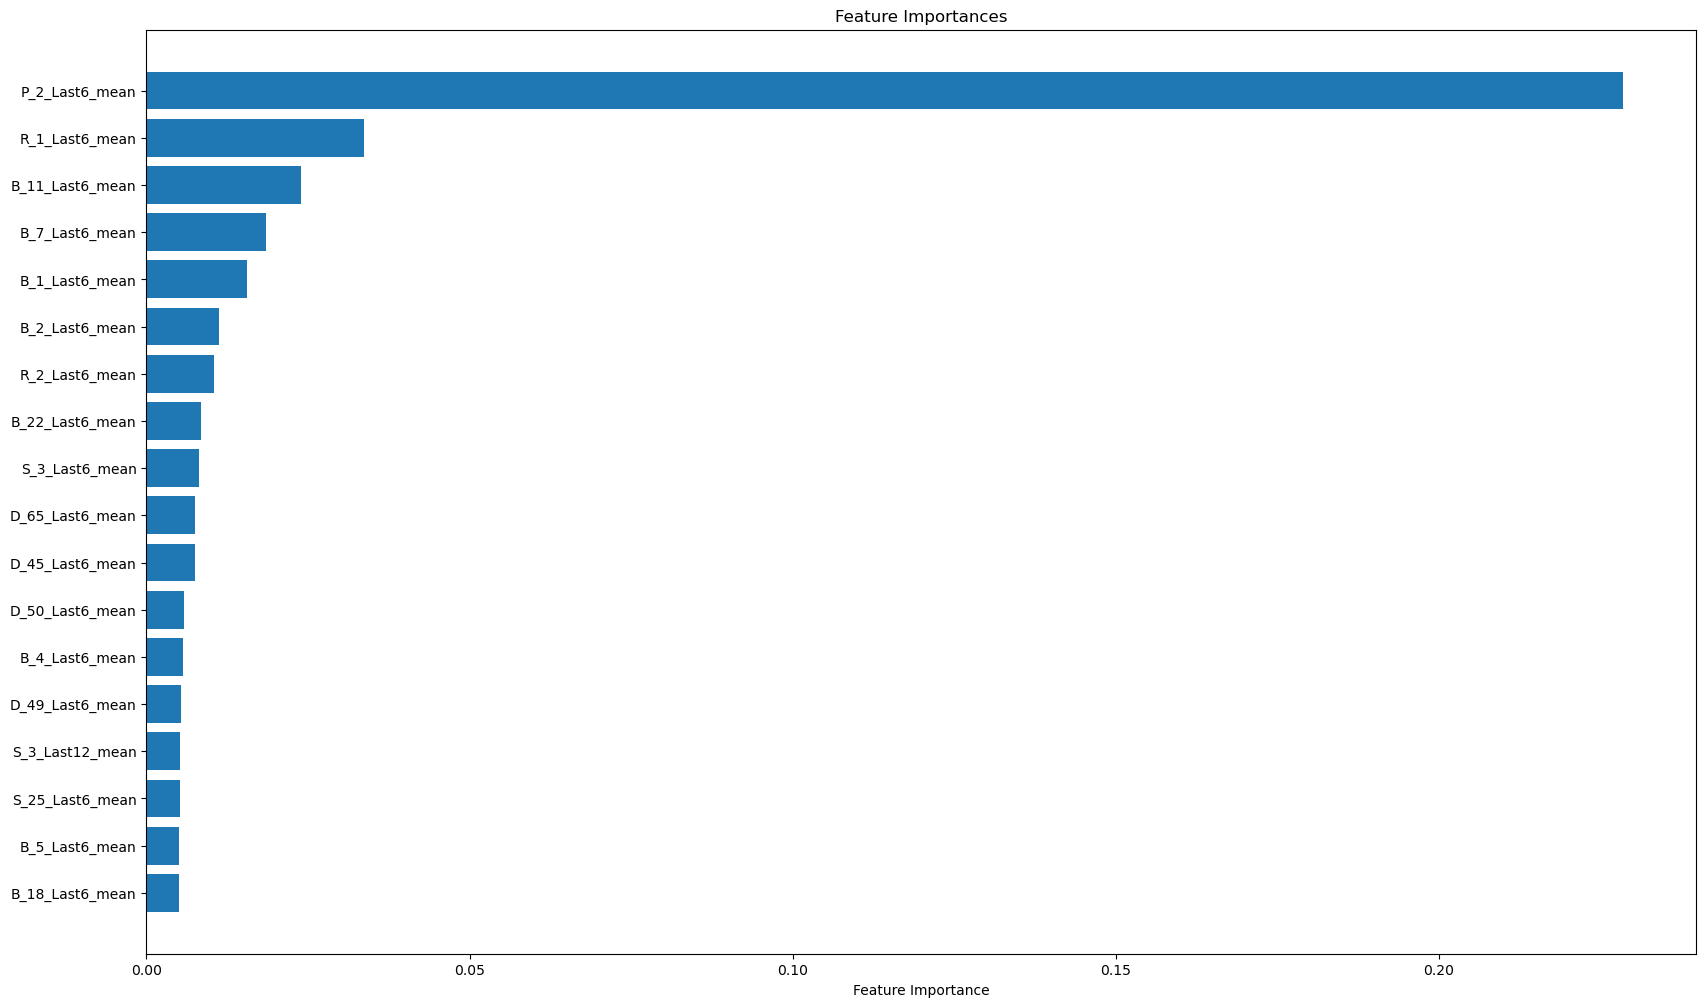

In [175]:
#Plot for default feature importance
plt.figure(figsize=(20, 12))
plt.barh(features_to_keep_graph1['Feature'], features_to_keep_graph1['Feature_Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [176]:
params = {
    'n_estimators': 300,
    'learning_rate': 0.5,
    'max_depth': 4,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'scale_pos_weight': 5,
    'random_state': 42  # Set random state for reproducibility
}

# Initialize XGBoost model
model_for_feature_reduction_2 = xgb.XGBClassifier(**params)
# Train the model
model_for_feature_reduction_2.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [178]:
acc_test1= model_for_feature_reduction_2.score(X_test1,Y_test1)
acc_test2= model_for_feature_reduction_2.score(X_test2,Y_test2)

In [179]:
acc_test1

0.9438255053776399

In [180]:
acc_test2

0.944512731523324

In [177]:
Feature_Importance_2 = pd.DataFrame(columns = ["Feature", "Feature_Importance"])
Feature_Importance_2.Feature = X_train.columns
Feature_Importance_2.Feature_Importance = model_for_feature_reduction_2.feature_importances_
Feature_Importance_2.sort_values(by=["Feature_Importance"], inplace=True, ascending=False)
Feature_Importance_2
Feature_Importance_2.to_csv("Feature_Importance_2.csv", index=False)

In [181]:
X_test1.shape

(165965, 666)

In [182]:
Feature_Importance_2


,Feature,Feature_Importance
399,P_2_Last6_mean,0.177391
403,R_1_Last6_mean,0.049822
401,B_1_Last6_mean,0.041369
511,B_33_Last6_mean,0.019619
409,D_44_Last6_mean,0.019398
...,...,...
152,D_123,0.000000
146,D_113,0.000000
145,S_27,0.000000
144,B_40,0.000000


In [183]:
features_to_keep_2 = Feature_Importance_2[Feature_Importance_2.Feature_Importance >= 0.005]
features_to_keep_2

,Feature,Feature_Importance
399,P_2_Last6_mean,0.177391
403,R_1_Last6_mean,0.049822
401,B_1_Last6_mean,0.041369
511,B_33_Last6_mean,0.019619
409,D_44_Last6_mean,0.019398
466,B_23_Last6_mean,0.015293
402,B_2_Last6_mean,0.012481
284,B_22_Last12_mean,0.012190
232,D_44_Last12_mean,0.010524
227,S_3_Last12_mean,0.009814


In [147]:
features_to_keep_2.to_csv('features_to_keep_2.csv',index=False)

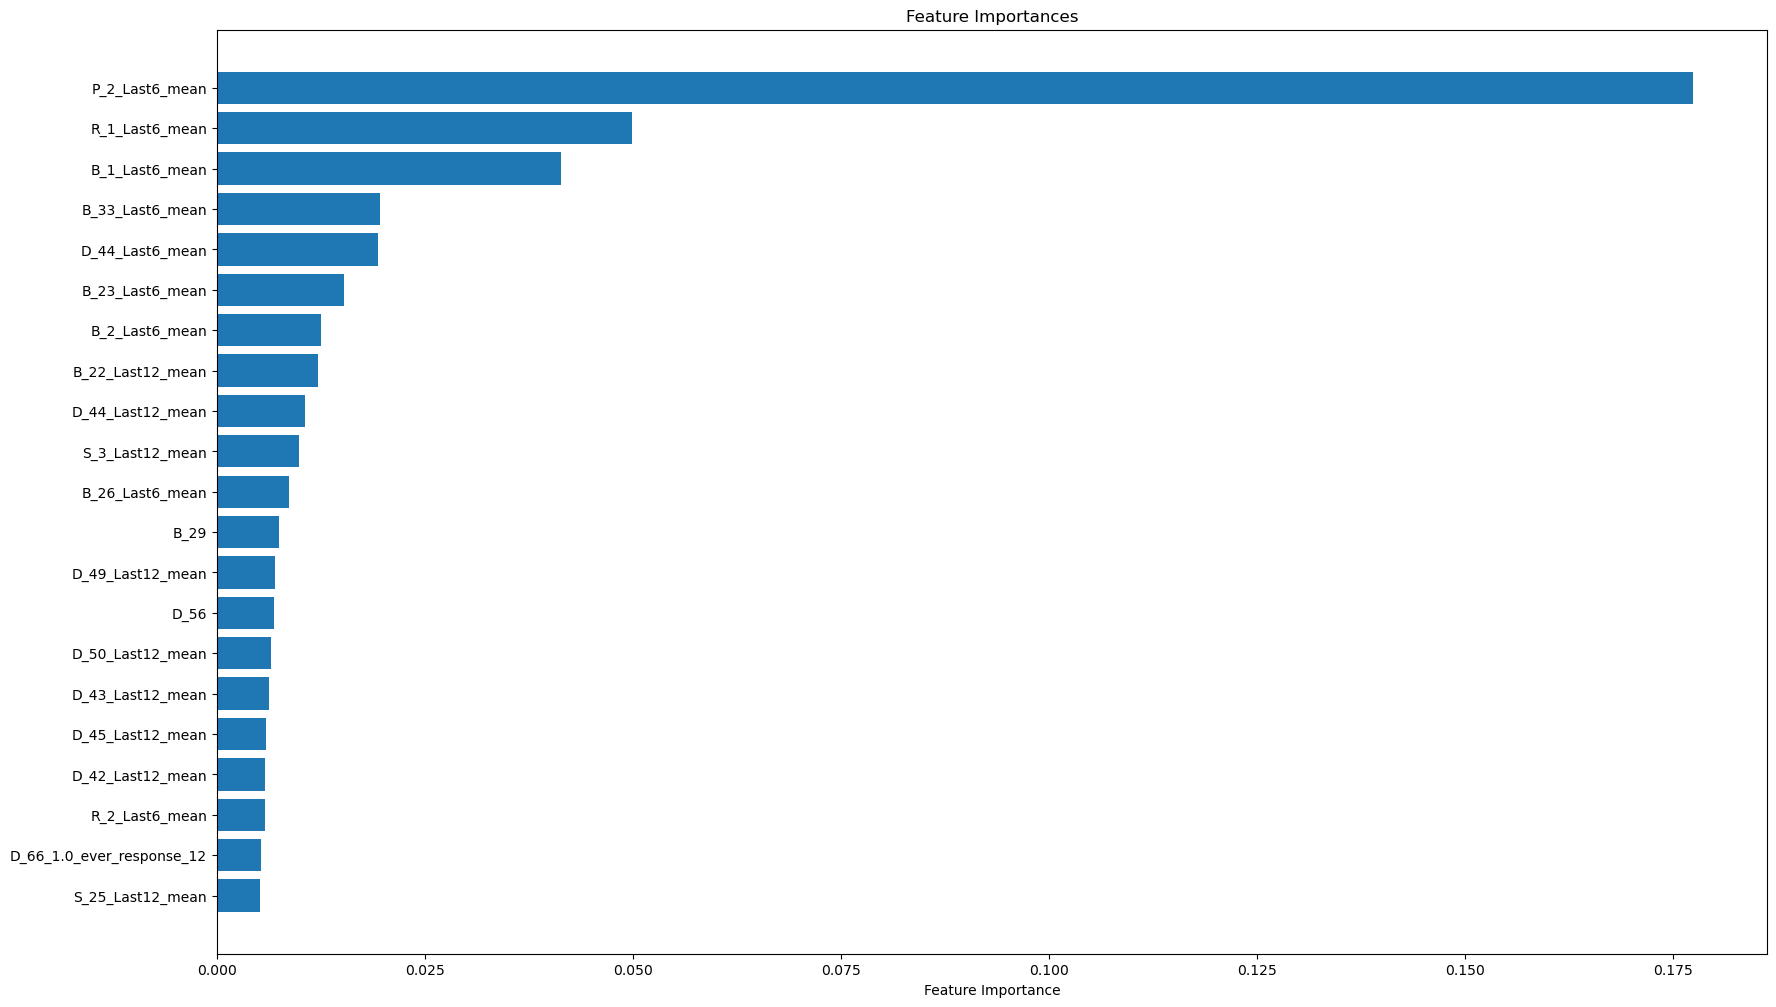

In [184]:
#Plot for default feature importance
plt.figure(figsize=(20, 12))
plt.barh(features_to_keep_2['Feature'], features_to_keep_2['Feature_Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [28]:
# features_to_keep = Feature_Importance[Feature_Importance.Feature_Importance >= 0.005]["Feature"]
# features_to_keep

In [185]:
features_to_keep_2 = Feature_Importance_2[Feature_Importance_2.Feature_Importance >= 0.005]
features_to_keep_2

,Feature,Feature_Importance
399,P_2_Last6_mean,0.177391
403,R_1_Last6_mean,0.049822
401,B_1_Last6_mean,0.041369
511,B_33_Last6_mean,0.019619
409,D_44_Last6_mean,0.019398
466,B_23_Last6_mean,0.015293
402,B_2_Last6_mean,0.012481
284,B_22_Last12_mean,0.012190
232,D_44_Last12_mean,0.010524
227,S_3_Last12_mean,0.009814


In [186]:
all_features_to_keep = pd.concat([features_to_keep_graph1, features_to_keep_2], axis=0).drop_duplicates(subset='Feature')
all_features_to_keep.sort_values(by=["Feature_Importance"], inplace=True, ascending=False)
all_features_to_keep

,Feature,Feature_Importance
399,P_2_Last6_mean,0.228404
403,R_1_Last6_mean,0.033608
430,B_11_Last6_mean,0.023920
511,B_33_Last6_mean,0.019619
409,D_44_Last6_mean,0.019398
419,B_7_Last6_mean,0.018524
401,B_1_Last6_mean,0.015592
466,B_23_Last6_mean,0.015293
284,B_22_Last12_mean,0.012190
402,B_2_Last6_mean,0.011169


In [148]:
all_features_to_keep.to_csv('features_to_keep_all_combines(all_features_to_keep).csv',index=False)

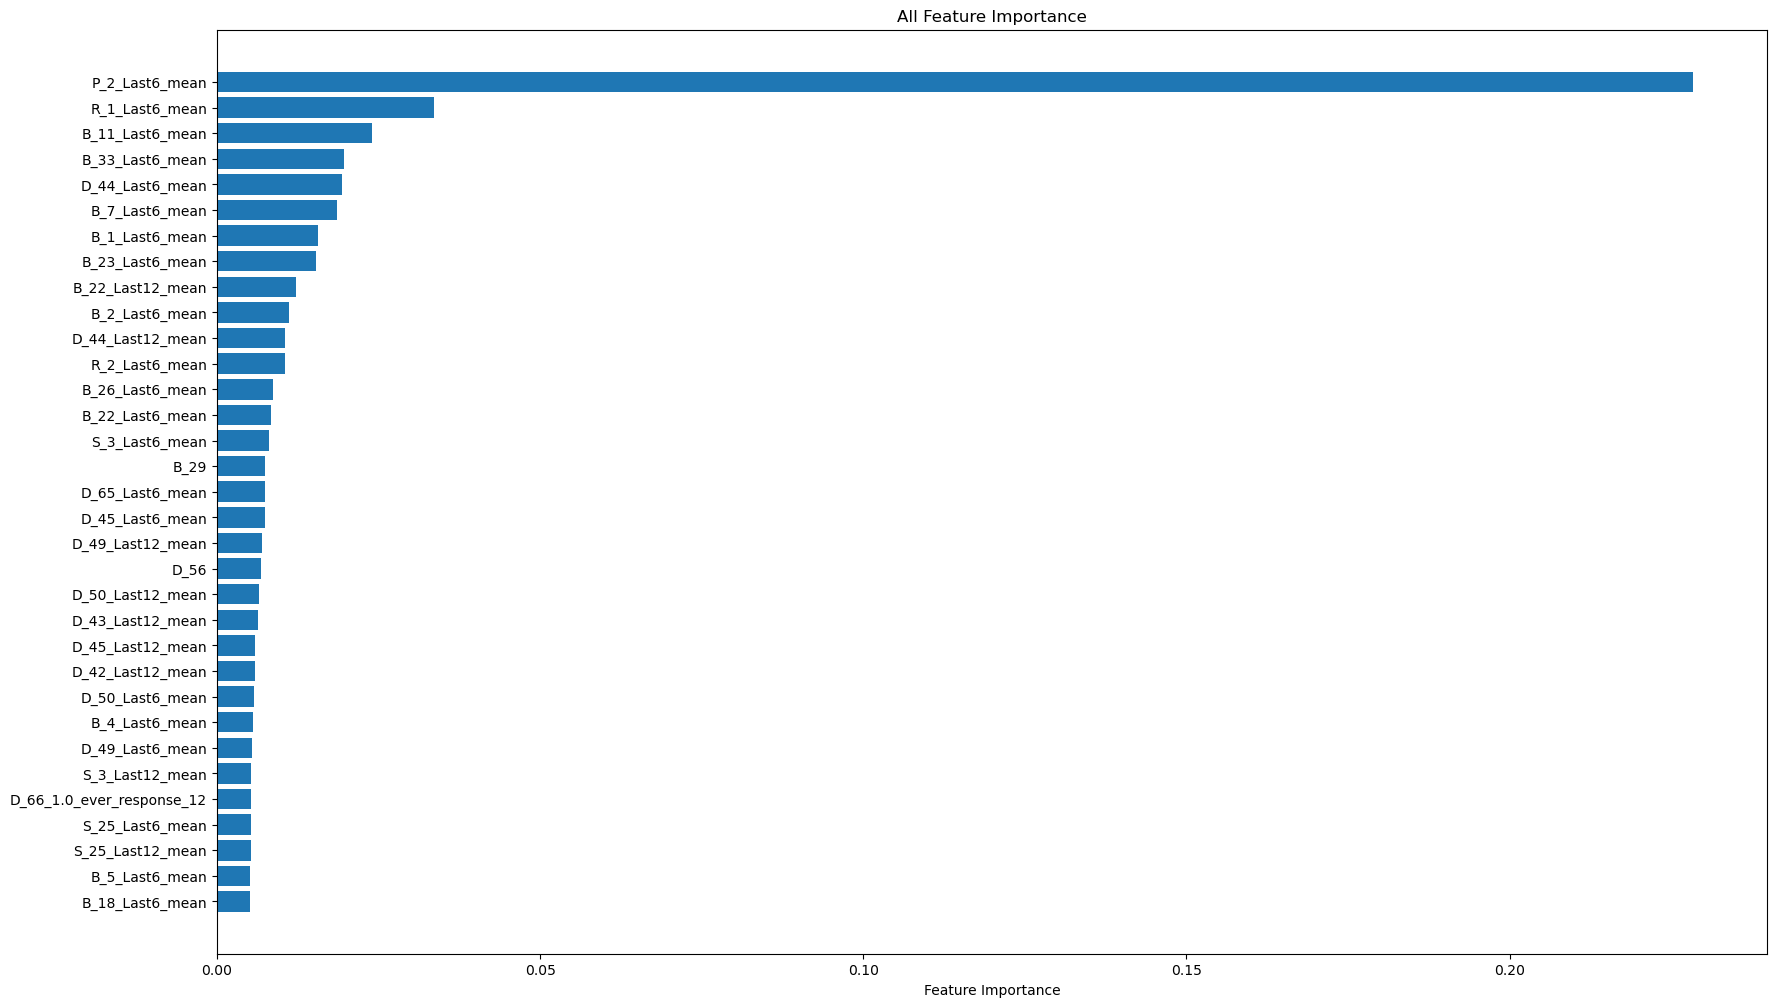

In [187]:
plt.figure(figsize=(20, 12))
plt.barh(all_features_to_keep['Feature'], all_features_to_keep['Feature_Importance'])
plt.xlabel('Feature Importance')
plt.title('All Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [92]:
# all_features_to_keep.to_csv('all_features_to_keep.csv',index=False)

In [188]:
features1 = Feature_Importance[Feature_Importance.Feature_Importance >= 0.005]["Feature"]
features2 = Feature_Importance_2[Feature_Importance_2.Feature_Importance >= 0.005]["Feature"]
all_feat_to_use = pd.concat([features1, features2]).unique()
all_feat_to_use

array(['P_2_Last6_mean', 'R_1_Last6_mean', 'B_11_Last6_mean',
       'B_7_Last6_mean', 'B_1_Last6_mean', 'B_2_Last6_mean',
       'R_2_Last6_mean', 'B_22_Last6_mean', 'S_3_Last6_mean',
       'D_65_Last6_mean', 'D_45_Last6_mean', 'D_50_Last6_mean',
       'B_4_Last6_mean', 'D_49_Last6_mean', 'S_3_Last12_mean',
       'S_25_Last6_mean', 'B_5_Last6_mean', 'B_18_Last6_mean',
       'B_33_Last6_mean', 'D_44_Last6_mean', 'B_23_Last6_mean',
       'B_22_Last12_mean', 'D_44_Last12_mean', 'B_26_Last6_mean', 'B_29',
       'D_49_Last12_mean', 'D_56', 'D_50_Last12_mean', 'D_43_Last12_mean',
       'D_45_Last12_mean', 'D_42_Last12_mean',
       'D_66_1.0_ever_response_12', 'S_25_Last12_mean'], dtype=object)

In [189]:
len(all_feat_to_use)

33

In [95]:
all_feat_to_use

array(['P_2_Last6_mean', 'R_1_Last6_mean', 'B_11_Last6_mean',
       'B_7_Last6_mean', 'B_1_Last6_mean', 'B_2_Last6_mean',
       'R_2_Last6_mean', 'B_22_Last6_mean', 'S_3_Last6_mean',
       'D_65_Last6_mean', 'D_45_Last6_mean', 'D_50_Last6_mean',
       'B_4_Last6_mean', 'D_49_Last6_mean', 'S_3_Last12_mean',
       'S_25_Last6_mean', 'B_5_Last6_mean', 'B_18_Last6_mean',
       'B_33_Last6_mean', 'D_44_Last6_mean', 'B_23_Last6_mean',
       'B_22_Last12_mean', 'D_44_Last12_mean', 'B_26_Last6_mean', 'B_29',
       'D_49_Last12_mean', 'D_56', 'D_50_Last12_mean', 'D_43_Last12_mean',
       'D_45_Last12_mean', 'D_42_Last12_mean',
       'D_66_1.0_ever_response_12', 'S_25_Last12_mean'], dtype=object)

In [195]:
X_train = X_train[all_feat_to_use]
X_test1 = X_test1[all_feat_to_use]
X_test2 = X_test2[all_feat_to_use]

In [196]:
X_train.to_csv('X_train_after_imp_feature_new.csv',index=False)

In [197]:
X_test1.to_csv('X_test1_after_imp_feature_new.csv',index=False)

In [198]:
X_test2.to_csv('X_test2_after_imp_feature_new.csv',index=False)

In [3]:
X_train= pd.read_csv("X_train_after_imp_feature_new.csv")

In [5]:
X_test1= pd.read_csv("X_test1_after_imp_feature_new.csv")

In [6]:
X_test2= pd.read_csv("X_test2_after_imp_feature_new.csv")

In [9]:
Y_train= pd.read_csv("Y_train.csv")

In [62]:
Y_test1= pd.read_csv("Y_test1.csv")

In [61]:
Y_test2= pd.read_csv("Y_test2.csv")

In [8]:
X_test2

,P_2_Last6_mean,R_1_Last6_mean,B_11_Last6_mean,B_7_Last6_mean,B_1_Last6_mean,B_2_Last6_mean,R_2_Last6_mean,B_22_Last6_mean,S_3_Last6_mean,D_65_Last6_mean,...,B_26_Last6_mean,B_29,D_49_Last12_mean,D_56,D_50_Last12_mean,D_43_Last12_mean,D_45_Last12_mean,D_42_Last12_mean,D_66_1.0_ever_response_12,S_25_Last12_mean
0,0.855054,0.006188,0.005810,0.027566,0.006203,0.816139,0.005583,0.004808,NaN,0.002936,...,0.006995,NaN,NaN,0.256485,0.136352,0.043072,0.258718,NaN,0.0,0.974179
1,0.912112,0.003930,0.004127,0.020281,0.006176,0.877197,0.003818,0.003584,0.142003,0.005089,...,0.003992,NaN,NaN,NaN,NaN,0.099016,0.565528,NaN,0.0,0.974198
2,0.591271,0.422810,0.159261,0.861108,0.197314,0.289141,0.005762,0.254805,0.716090,0.005991,...,0.002877,NaN,NaN,NaN,0.119318,0.277826,0.376052,NaN,1.0,0.972766
3,0.596196,0.171077,0.005367,0.038548,0.006439,0.745122,0.004407,0.004963,0.145575,0.008515,...,0.021834,NaN,NaN,NaN,0.226055,0.051356,0.292503,NaN,0.0,0.974509
4,0.558786,0.004319,0.768605,0.652536,0.822165,0.022389,0.004653,0.507049,0.493719,0.005236,...,0.006653,NaN,NaN,NaN,NaN,0.005286,0.024895,0.107169,0.0,0.976194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165961,0.802432,0.006243,0.009729,0.034624,0.019085,0.838852,0.005093,0.006409,0.191377,0.024867,...,0.019725,NaN,NaN,0.400995,NaN,0.007631,0.614754,NaN,0.0,0.973306
165962,0.726443,0.002517,0.278215,0.538135,0.296882,0.072657,0.004288,0.503937,0.142255,0.007288,...,0.005274,NaN,0.193588,NaN,NaN,0.066790,0.762555,NaN,0.0,0.974750
165963,0.992953,0.007906,0.009749,0.022402,0.020482,0.989777,0.005229,0.005429,0.116688,0.006469,...,0.003992,NaN,NaN,0.211120,0.318451,0.098713,0.509259,NaN,0.0,0.974416
165964,0.689785,0.003891,0.173746,0.135492,0.162936,0.151117,0.006168,0.090386,0.122600,0.004515,...,0.005335,0.00888,NaN,0.197095,0.074307,NaN,0.305933,NaN,0.0,0.780968


In [192]:
# Step 11: XGBoost Grid Search
from sklearn.metrics import roc_auc_score
Grid_Search_Results = pd.DataFrame(columns = ["Number Trees", "Learning Rate", 'Subsample', '% Features', 'Weight of Default',"AUC Train", "AUC Test 1", "AUC Test 2"])

Counter = 0
for n_trees in [50, 100, 300]:
    for lr in [0.01, 0.1]:
        for subsample in [0.5, 0.8]:
            for colsample in [0.5, 1.0]:
                for weight in [1, 5, 10]:
                    xgb_instance = XGBClassifier(n_estimators= n_trees, learning_rate = lr,subsample=subsample, colsample_bytree=colsample, scale_pos_weight=weight)
                    model = xgb_instance.fit(X_train, Y_train)
                    Grid_Search_Results.loc[Counter,"Number Trees"] = n_trees
                    Grid_Search_Results.loc[Counter,"Learning Rate"] = lr
                    Grid_Search_Results.loc[Counter,"Subsample"] = subsample
                    Grid_Search_Results.loc[Counter,"% Features"] = colsample
                    Grid_Search_Results.loc[Counter,"Weight of Default"] = weight
                    Grid_Search_Results.loc[Counter,"AUC Train"] = roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 1"] = roc_auc_score(Y_test1, model.predict_proba(X_test1)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 2"] = roc_auc_score(Y_test2, model.predict_proba(X_test2)[:,1])

                    Counter = Counter + 1
                    Grid_Search_Results.to_csv("Grid_Search_Results1.csv")

In [38]:
Grid_Search_Results

,Number Trees,Learning Rate,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2
0,50,0.01,0.5,0.5,1,0.951565,0.951596,0.950905
1,50,0.01,0.5,0.5,5,0.949629,0.949689,0.949054
2,50,0.01,0.5,0.5,10,0.949029,0.94909,0.9485
3,50,0.01,0.5,1.0,1,0.948806,0.948545,0.94817
4,50,0.01,0.5,1.0,5,0.945781,0.945513,0.945439
...,...,...,...,...,...,...,...,...
67,300,0.1,0.8,0.5,5,0.98328,0.981667,0.981217
68,300,0.1,0.8,0.5,10,0.982365,0.980733,0.980314
69,300,0.1,0.8,1.0,1,0.986259,0.984501,0.983831
70,300,0.1,0.8,1.0,5,0.984987,0.983272,0.982892


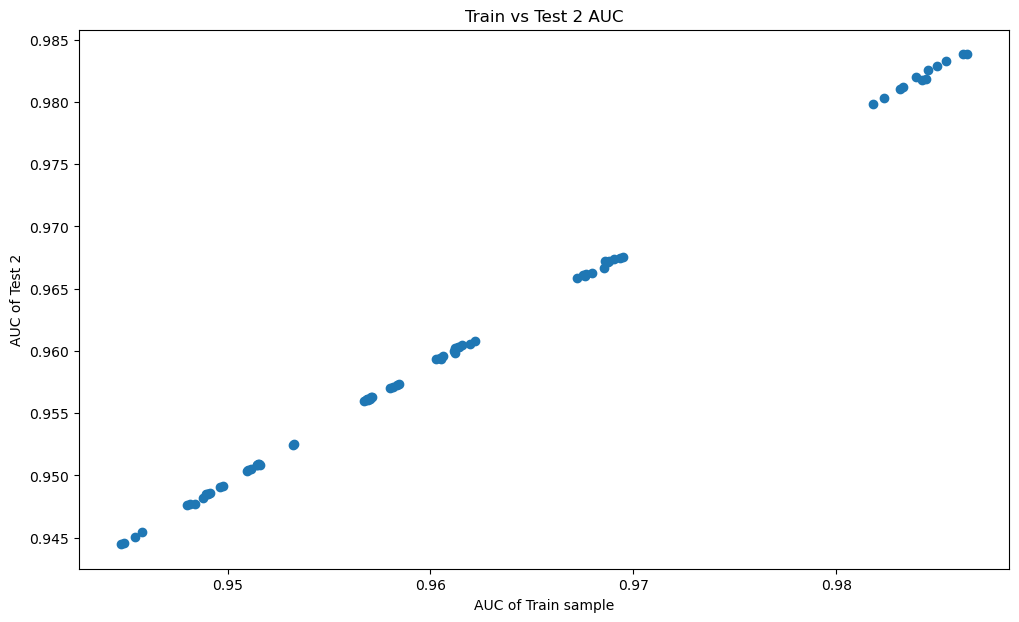

In [39]:
plt.figure(figsize=(12, 7))
plt.scatter(Grid_Search_Results['AUC Train'], Grid_Search_Results['AUC Test 2'])
xlab = 'AUC of Train sample'
ylab = 'AUC of Test 2'
title = 'Train vs Test 2 AUC'
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.show()

In [41]:
AUC_AVG = (Grid_Search_Results['AUC Train'] + Grid_Search_Results['AUC Test 1'] + Grid_Search_Results['AUC Test 2']) / 3
AUC_SD = []
for i in range(72):
    AUC_SD.append(np.std([Grid_Search_Results['AUC Train'][i], Grid_Search_Results['AUC Test 1'][i], Grid_Search_Results['AUC Test 2'][i]]))

Grid_Search_Results['AUC AVG'] = AUC_AVG
Grid_Search_Results['AUC SD'] = AUC_SD

In [42]:
Grid_Search_Results

,Number Trees,Learning Rate,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,AUC AVG,AUC SD
0,50,0.01,0.5,0.5,1,0.951565,0.951596,0.950905,0.951355,0.000319
1,50,0.01,0.5,0.5,5,0.949629,0.949689,0.949054,0.949458,0.000286
2,50,0.01,0.5,0.5,10,0.949029,0.94909,0.9485,0.948873,0.000265
3,50,0.01,0.5,1.0,1,0.948806,0.948545,0.94817,0.948507,0.000261
4,50,0.01,0.5,1.0,5,0.945781,0.945513,0.945439,0.945578,0.000147
...,...,...,...,...,...,...,...,...,...,...
67,300,0.1,0.8,0.5,5,0.98328,0.981667,0.981217,0.982055,0.000886
68,300,0.1,0.8,0.5,10,0.982365,0.980733,0.980314,0.981137,0.000885
69,300,0.1,0.8,1.0,1,0.986259,0.984501,0.983831,0.984864,0.001024
70,300,0.1,0.8,1.0,5,0.984987,0.983272,0.982892,0.983717,0.000911


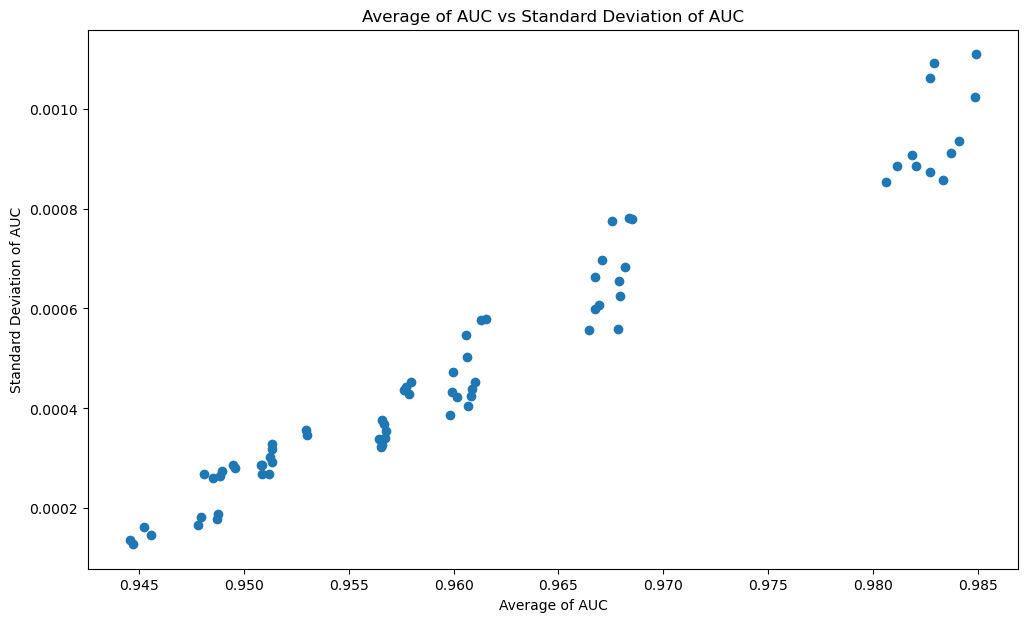

In [43]:
plt.figure(figsize=(12, 7))
plt.scatter(Grid_Search_Results['AUC AVG'], Grid_Search_Results['AUC SD'])
xlab = 'Average of AUC'
ylab = 'Standard Deviation of AUC'
title = 'Average of AUC vs Standard Deviation of AUC'
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.show()

In [120]:
# Step 12: Choose best XGBoost model
best_model_idx = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1).idxmax()
best_params = Grid_Search_Results.iloc[best_model_idx].to_dict()
best_params

{'Number Trees': 300,
 'Learning Rate': 0.1,
 'Subsample': 0.5,
 '% Features': 1.0,
 'Weight of Default': 1,
 'AUC Train': 0.9864363931223391,
 'AUC Test 1': 0.9844763299918364,
 'AUC Test 2': 0.9838279057300264,
 'AUC AVG': 0.9849135429480672,
 'AUC SD': 0.001108878711667981}

In [121]:
best_xgb_instance = xgb.XGBClassifier(
    n_estimators=best_params['Number Trees'],
    learning_rate=best_params['Learning Rate'],
    subsample=best_params['Subsample'],
    colsample_bytree=best_params['% Features'],
    scale_pos_weight=best_params['Weight of Default']
)

# Fit the model on the training data
best_xgb_model = best_xgb_instance.fit(X_train, Y_train)

In [47]:
from sklearn.metrics import accuracy_score


In [76]:
# Y_pred = best_xgb_model.predict(X_test1)
# accuracy = accuracy_score(Y_test, Y_pred)

acc_test1= best_xgb_model.score(X_test1,Y_test1)

In [77]:
acc_test1

0.9406682131774772

In [78]:
acc_test2= best_xgb_model.score(X_test2,Y_test2)
acc_test2

0.9393791499463745

In [79]:
best_xgb_model.predict(X_train)[:5]

array([0, 0, 0, 0, 1])

In [80]:
best_xgb_model.predict_proba(X_train)[:5]

array([[9.9709123e-01, 2.9087921e-03],
       [9.9969769e-01, 3.0234293e-04],
       [9.9962503e-01, 3.7494677e-04],
       [6.3115156e-01, 3.6884847e-01],
       [8.8984370e-02, 9.1101563e-01]], dtype=float32)

In [54]:
best_xgb_model.save_model('best_xgb_model.json')

AUC on Train: 0.9866740134781614
AUC on Test 1: 0.9846995231149991
AUC on Test 2: 0.9841909591573759


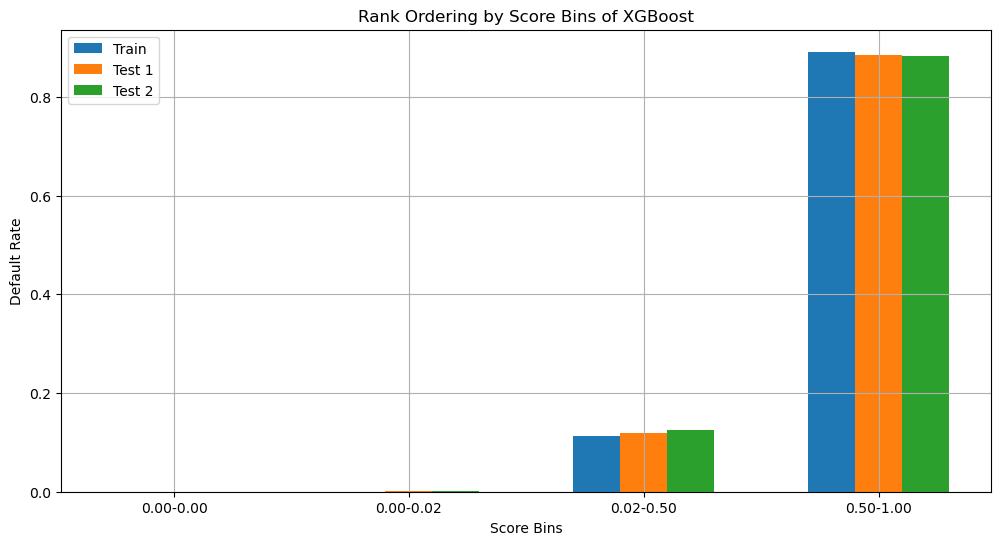

In [138]:
# Calculate AUC on each sample
auc_train = roc_auc_score(Y_train, best_xgb_model.predict_proba(X_train)[:, 1])
auc_test1 = roc_auc_score(Y_test1, best_xgb_model.predict_proba(X_test1)[:, 1])
auc_test2 = roc_auc_score(Y_test2, best_xgb_model.predict_proba(X_test2)[:, 1])

print(f"AUC on Train: {auc_train}")
print(f"AUC on Test 1: {auc_test1}")
print(f"AUC on Test 2: {auc_test2}")

# Define score bins based on the train sample
train_scores = best_xgb_model.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = best_xgb_model.predict_proba(X_test1)[:, 1]
test2_scores = best_xgb_model.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
   default_rates = []
   for i in range(len(bins) - 1):
       mask = (scores >= bins[i]) & (scores <= bins[i + 1])
       if np.sum(mask) > 0:
           default_rate = np.sum(y[mask]) / np.sum(mask)
           default_rates.append(default_rate)
       else:
           default_rates.append(0.0)
   return default_rates

default_rates_train = calculate_default_rate(train_scores, Y_train)
default_rates_test1 = calculate_default_rate(test1_scores, Y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, Y_test2)

# Modify the x-axis labels to include the values of the score bins
x_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

# Create a figure for the bar chart
plt.figure(figsize=(12, 6))

# Plot the default rates for different samples in the respective score bins
width = 0.2
x_indexes = np.arange(len(x_labels))
plt.bar(x_indexes - width, default_rates_train, width=width, label='Train', align='center')
plt.bar(x_indexes, default_rates_test1, width=width, label='Test 1', align='center')
plt.bar(x_indexes + width, default_rates_test2, width=width, label='Test 2', align='center')

# Set labels, title, and x-axis ticks
plt.xlabel('Score Bins')
plt.ylabel('Default Rate')
plt.title('Rank Ordering by Score Bins of XGBoost')
plt.xticks(x_indexes, x_labels)  # Use modified x_labels

# Add a legend, grid, and display the plot
plt.legend()
plt.grid(True)
plt.show()

In [61]:
pip install shap

   ---------------------------------------- 0.0/453.1 kB ? eta -:--:--
   ----------------------------- --------- 337.9/453.1 kB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 453.1/453.1 kB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
import shap
shap.initjs()
explainer = shap.Explainer(best_xgb_model)

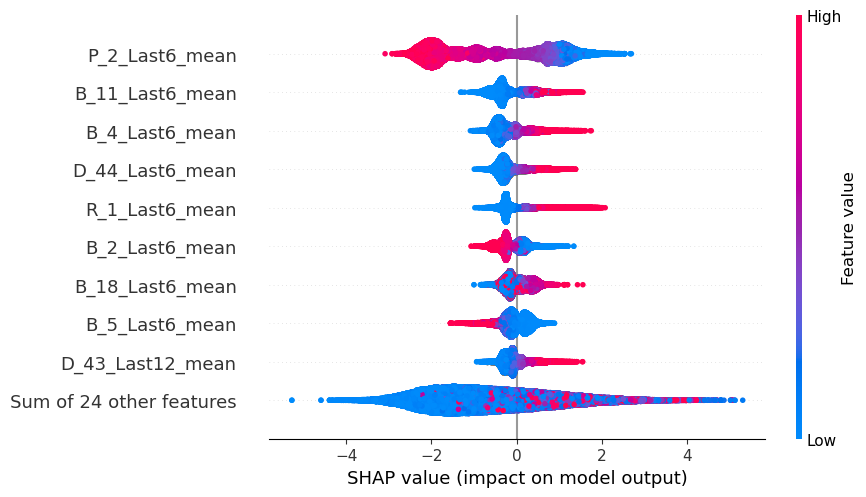

In [63]:
shap_values = explainer(X_test2)
shap.plots.beeswarm(shap_values)

In [64]:
explainer = shap.Explainer(best_xgb_model)

In [66]:
shap_values = explainer(X_test2)

In [67]:
shap_values

.values =
array([[-2.054171  , -0.23451926, -0.6230384 , ..., -0.10464671,
         0.00828573, -0.0704947 ],
       [-2.083728  , -0.29372483, -0.7952074 , ..., -0.11655419,
         0.04026045, -0.16079018],
       [ 0.21717729,  0.5110579 ,  0.26149863, ..., -0.02993615,
        -0.07478466,  0.068718  ],
       ...,
       [-1.9550159 , -0.1889044 , -0.39018485, ..., -0.08281996,
         0.03232728, -0.27977934],
       [-0.7876512 , -0.21975164,  0.31118897, ..., -0.03574127,
         0.01923614,  0.08144971],
       [ 0.8287129 ,  0.37829328,  0.21770938, ..., -0.05527581,
        -0.05189157, -0.04137463]], dtype=float32)

.base_values =
array([-1.1712601, -1.1712601, -1.1712601, ..., -1.1712601, -1.1712601,
       -1.1712601], dtype=float32)

.data =
array([[0.85505433, 0.00618835, 0.00581035, ...,        nan, 0.        ,
        0.97417944],
       [0.91211197, 0.0039298 , 0.00412694, ...,        nan, 0.        ,
        0.97419836],
       [0.59127138, 0.42281034, 0.15926134

In [68]:
# Identify the top 5 features with the highest average SHAP values
feature_names = X_test2.columns
avg_shap_values = np.abs(shap_values.values).mean(axis=0)
top_features_idx = np.argsort(avg_shap_values)[-5:][::-1]
top_features = [feature_names[i] for i in top_features_idx]


In [70]:
top_features

['P_2_Last6_mean',
 'B_11_Last6_mean',
 'B_4_Last6_mean',
 'D_44_Last6_mean',
 'R_1_Last6_mean']

In [71]:
# Calculate the requested summary statistics for the top features
summary_stats = []
for feature in top_features:
    feature_values = X_test2[feature]
    feature_values_no_na = feature_values.dropna()  # Handle missing values
    summary = [
        feature,
        feature_values_no_na.min(),
        np.percentile(feature_values_no_na, 1),
        np.percentile(feature_values_no_na, 5),
        np.median(feature_values_no_na),
        np.percentile(feature_values_no_na, 95),
        np.percentile(feature_values_no_na, 99),
        feature_values_no_na.max(),
        feature_values_no_na.mean(),
        100 * (len(X_test2) - len(feature_values_no_na)) / len(X_test2)  # Percent missing
    ]
    summary_stats.append(summary)

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(
    summary_stats,
    columns=["Feature", "Min", "1st Percentile", "5th Percentile", "Median", "95th Percentile", "99th Percentile", "Max", "Mean", "%Missing"]
)

print(summary_df)

           Feature           Min  1st Percentile  5th Percentile    Median  \
0   P_2_Last6_mean -3.110929e-01       -0.000181        0.196104  0.697090   
1  B_11_Last6_mean  1.237040e-04        0.002998        0.004080  0.024938   
2   B_4_Last6_mean  2.525359e-05        0.003920        0.006207  0.087578   
3  D_44_Last6_mean  3.776102e-05        0.002481        0.003356  0.006485   
4   R_1_Last6_mean  6.440720e-07        0.002460        0.003293  0.005811   

   95th Percentile  99th Percentile       Max      Mean  %Missing  
0         0.971324         1.003364  1.009209  0.651503  0.469373  
1         0.588135         0.983942  1.504582  0.117151  0.000000  
2         0.642622         1.011498  3.362615  0.181774  0.000000  
3         0.628070         1.041382  3.130538  0.129260  4.093007  
4         0.505837         1.003239  2.006159  0.091644  0.000000  


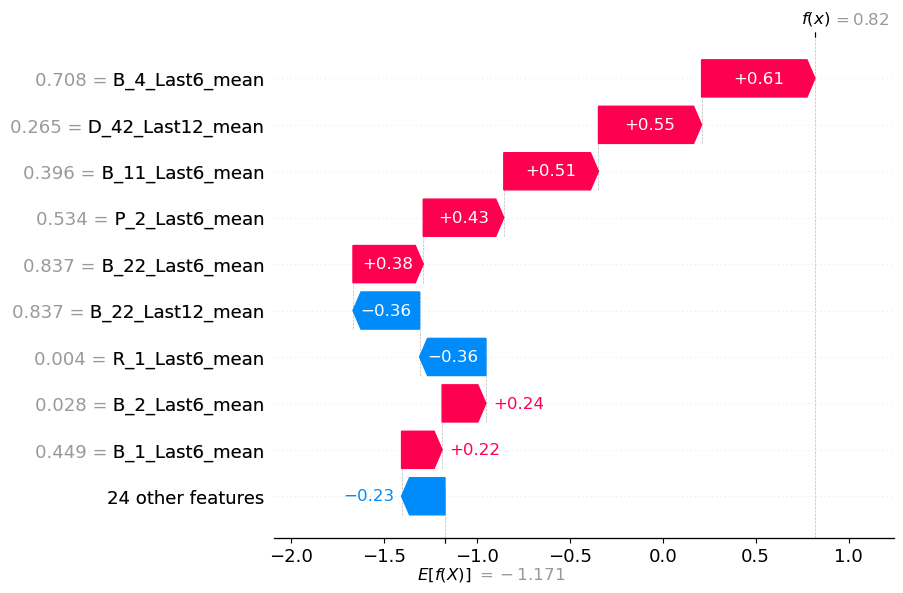

In [72]:
shap.plots.waterfall(shap_values[160])

In [81]:
# Step 13: Data Processing for Neural Network
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()

X_train_nn = imputer.fit_transform(X_train)
X_test1_nn = imputer.transform(X_test1)
X_test2_nn = imputer.transform(X_test2)

X_train_nn = scaler.fit_transform(np.clip(X_train_nn, np.percentile(X_train_nn, 1), np.percentile(X_train_nn, 99)))
X_test1_nn = scaler.transform(np.clip(X_test1_nn, np.percentile(X_train_nn, 1), np.percentile(X_train_nn, 99)))
X_test2_nn = scaler.transform(np.clip(X_test2_nn, np.percentile(X_train_nn, 1), np.percentile(X_train_nn, 99)))

In [83]:
# Step 13: Data Processing for Neural Network
outlier = pd.DataFrame(columns=["Column Name", "P1", "P99"])

counter = 0
for feature in all_feat_to_use:
    outlier.loc[counter, "Column Name"] = feature
    outlier.loc[counter, "P1"] = df_new_all[feature].quantile(0.01)
    outlier.loc[counter, "P99"] = df_new_all[feature].quantile(0.99)
    counter += 1

outlier

,Column Name,P1,P99
0,P_2_Last6_mean,-0.000246,1.003271
1,R_1_Last6_mean,0.002462,1.001768
2,B_11_Last6_mean,0.003008,0.990197
3,B_7_Last6_mean,0.005372,0.941125
4,B_1_Last6_mean,0.003259,0.983407
5,B_2_Last6_mean,0.016715,1.006908
6,R_2_Last6_mean,0.002331,1.004248
7,B_22_Last6_mean,0.002433,0.919703
8,S_3_Last6_mean,0.011757,0.946424
9,D_65_Last6_mean,0.002337,0.961781


In [84]:
# Next we replace outlers with P1 and P99
import numpy as np

for counter in range (outlier.shape[0]):
    X_train[outlier.loc[counter, "Column Name"]] = np.where(X_train[outlier.loc[counter, "Column Name"]] < outlier.loc[counter, "P1"],
                                                       outlier.loc[counter, "P1"], X_train[outlier.loc[counter, "Column Name"]])

    X_train[outlier.loc[counter, "Column Name"]] = np.where(X_train[outlier.loc[counter, "Column Name"]] > outlier.loc[counter, "P99"],
                                                       outlier.loc[counter, "P99"], X_train[outlier.loc[counter, "Column Name"]])


C:\Users\yxb220022\AppData\Local\Temp\ipykernel_2072\330961753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[outlier.loc[counter, "Column Name"]] = np.where(X_train[outlier.loc[counter, "Column Name"]] < outlier.loc[counter, "P1"],
C:\Users\yxb220022\AppData\Local\Temp\ipykernel_2072\330961753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[outlier.loc[counter, "Column Name"]] = np.where(X_train[outlier.loc[counter, "Column Name"]] > outlier.loc[counter, "P99"],


In [85]:
# Next we do the same for test samples. Note we use the same P1/P99 that we got from train sample.
# Test sample represents unseen data, and should not be used in any stage of the model, including data processing.

for counter in range (outlier.shape[0]):
    X_test1[outlier.loc[counter, "Column Name"]] = np.where(X_test1[outlier.loc[counter, "Column Name"]] < outlier.loc[counter, "P1"],
                                                       outlier.loc[counter, "P1"], X_test1[outlier.loc[counter, "Column Name"]])

    X_test2[outlier.loc[counter, "Column Name"]] = np.where(X_test2[outlier.loc[counter, "Column Name"]] < outlier.loc[counter, "P1"],
                                                       outlier.loc[counter, "P1"], X_test2[outlier.loc[counter, "Column Name"]])

    X_test1[outlier.loc[counter, "Column Name"]] = np.where(X_test1[outlier.loc[counter, "Column Name"]] > outlier.loc[counter, "P99"],
                                                       outlier.loc[counter, "P99"], X_test1[outlier.loc[counter, "Column Name"]])

    X_test2[outlier.loc[counter, "Column Name"]] = np.where(X_test2[outlier.loc[counter, "Column Name"]] > outlier.loc[counter, "P99"],
                                                       outlier.loc[counter, "P99"], X_test2[outlier.loc[counter, "Column Name"]])

In [86]:
# Feature Scaling: We will use StandardScaler. There are other scaling options such as Min-Max Scaler.
# No matter which technique to use, again scaling parameters (here mean and STD) should come from the train sample.
# To find scaling parameters, we use a sklearn package.

# get scaling parameters
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

# scale features
X_train = pd.DataFrame(sc.transform(X_train), columns = X_train.columns)
X_test1 = pd.DataFrame(sc.transform(X_test1), columns = X_test1.columns)
X_test2 = pd.DataFrame(sc.transform(X_test2), columns = X_test2.columns)

In [87]:
# For missing value imputation, we replace all missing values with 0
X_train

,P_2_Last6_mean,R_1_Last6_mean,B_11_Last6_mean,B_7_Last6_mean,B_1_Last6_mean,B_2_Last6_mean,R_2_Last6_mean,B_22_Last6_mean,S_3_Last6_mean,D_65_Last6_mean,...,B_26_Last6_mean,B_29,D_49_Last12_mean,D_56,D_50_Last12_mean,D_43_Last12_mean,D_45_Last12_mean,D_42_Last12_mean,D_66_1.0_ever_response_12,S_25_Last12_mean
0,0.077002,-0.451838,-0.465270,-0.763565,-0.509561,1.058447,-0.290131,-0.545014,-0.619790,-0.264508,...,-0.199542,-0.11184,NaN,NaN,NaN,-0.817812,-0.821355,NaN,-0.509546,0.083397
1,1.261689,-0.454303,-0.294849,-0.634864,-0.319694,1.013263,-0.317603,-0.559643,-0.882429,-0.251438,...,-0.209445,NaN,NaN,-0.560923,-0.449541,-0.597961,-0.287373,NaN,1.962531,0.383868
2,0.507031,-0.456663,-0.502029,-0.744110,-0.470231,1.050690,-0.314034,-0.547745,-0.675704,-0.253228,...,-0.207744,NaN,NaN,0.024317,-0.259190,0.143345,-0.460249,NaN,-0.509546,0.380380
3,-0.429155,0.432218,1.421427,2.061044,1.572035,-1.511573,-0.313303,1.958831,-0.349358,-0.258124,...,-0.203380,NaN,NaN,-1.059488,-0.603180,-0.461490,1.279940,NaN,-0.509546,0.370630
4,-0.640876,-0.000472,2.901009,1.078234,2.734285,-1.525191,-0.306202,1.552944,-0.304982,-0.262174,...,-0.203455,NaN,NaN,NaN,NaN,-0.392410,-0.979370,0.737072,-0.509546,0.022944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774498,-1.477065,1.312989,0.157818,-0.112820,0.231812,-0.797818,0.626957,-0.539734,1.192522,6.701539,...,2.541166,NaN,-0.389689,NaN,NaN,4.569784,-0.964232,0.282270,-0.509546,-3.218653
774499,-0.064164,1.769464,-0.173954,-0.312802,-0.275895,-0.596587,-0.311367,1.554858,-0.383478,-0.257311,...,-0.217633,NaN,NaN,-1.020600,NaN,0.563786,1.122809,NaN,-0.509546,0.392977
774500,0.059382,-0.452860,2.061028,1.113576,2.210606,-1.092424,-0.324396,1.131783,-0.433351,-0.272746,...,-0.201651,NaN,NaN,NaN,-0.489557,-0.329194,0.097091,NaN,1.962531,0.382199
774501,-0.590373,-0.007220,-0.184431,-0.450806,-0.235893,-1.140739,-0.305931,0.713495,0.689716,-0.252728,...,-0.211493,NaN,NaN,-1.117602,NaN,0.066873,-0.278910,NaN,-0.509546,0.378791


In [88]:
# For missing value imputation, we replace all missing values with 0
X_train.fillna(0,inplace=True)
X_test1.fillna(0,inplace=True)
X_test2.fillna(0,inplace=True)

In [90]:
all_feat_to_use

array(['P_2_Last6_mean', 'R_1_Last6_mean', 'B_11_Last6_mean',
       'B_7_Last6_mean', 'B_1_Last6_mean', 'B_2_Last6_mean',
       'R_2_Last6_mean', 'B_22_Last6_mean', 'S_3_Last6_mean',
       'D_65_Last6_mean', 'D_45_Last6_mean', 'D_50_Last6_mean',
       'B_4_Last6_mean', 'D_49_Last6_mean', 'S_3_Last12_mean',
       'S_25_Last6_mean', 'B_5_Last6_mean', 'B_18_Last6_mean',
       'B_33_Last6_mean', 'D_44_Last6_mean', 'B_23_Last6_mean',
       'B_22_Last12_mean', 'D_44_Last12_mean', 'B_26_Last6_mean', 'B_29',
       'D_49_Last12_mean', 'D_56', 'D_50_Last12_mean', 'D_43_Last12_mean',
       'D_45_Last12_mean', 'D_42_Last12_mean',
       'D_66_1.0_ever_response_12', 'S_25_Last12_mean'], dtype=object)

In [91]:
pip install tensorflow


     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
    --------------------------------------- 4.8/377.0 MB 104.2 MB/s eta 0:00:04
   - -------------------------------------- 9.9/377.0 MB 106.6 MB/s eta 0:00:04
   - ------------------------------------- 11.5/377.0 MB 108.8 MB/s eta 0:00:04
   - -------------------------------------- 16.6/377.0 MB 81.8 MB/s eta 0:00:05
   - -------------------------------------- 18.5/377.0 MB 65.6 MB/s eta 0:00:06
   -- ------------------------------------- 23.9/377.0 MB 81.8 MB/s eta 0:00:05
   --- ----------------------------------- 29.3/377.0 MB 108.8 MB/s eta 0:00:04
   --- ----------------------------------- 34.7/377.0 MB 108.8 MB/s eta 0:00:04
   --- ----------------------------------- 36.7/377.0 MB 108.8 MB/s eta 0:00:04
   ---- ----------------------------------- 41.1/377.0 M

In [92]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_auc_score

In [93]:
Grid_Search_Results_nn = pd.DataFrame(columns = ["HL", "Nodes", "Activation Function","Dropout", "Batch Size",
                                              "AUC Train", "AUC Test 1", "AUC Test 2"])

In [94]:
Counter = 0
for n_layers in [2, 4]:
    for n_nodes in [4, 6]:
        for activation in ['relu', 'tanh']:
            for dropout in [0 , 0.5]:
                for batch_size in [100, 10000]:
                    model = Sequential()
                    model.add(Dense(n_nodes, input_dim=X_train_nn.shape[1], activation=activation))
                    model.add(Dropout(dropout))
                    for _ in range(n_layers - 1):
                        model.add(Dense(n_nodes, activation=activation))
                        model.add(Dropout(dropout))
                    model.add(Dense(1, activation='sigmoid'))
                    model.compile(optimizer=Adam(), loss=BinaryCrossentropy())
                    model.fit(X_train_nn, Y_train, batch_size=batch_size, epochs=20, verbose=0)

                    Grid_Search_Results_nn.loc[Counter,"HL"] = n_layers
                    Grid_Search_Results_nn.loc[Counter,"Nodes"] = n_nodes
                    Grid_Search_Results_nn.loc[Counter,"Activation Function"] = activation
                    Grid_Search_Results_nn.loc[Counter,"Dropout"] = dropout
                    Grid_Search_Results_nn.loc[Counter,"Batch Size"] = batch_size
                    Grid_Search_Results_nn.loc[Counter,"AUC Train"] = roc_auc_score(Y_train, model.predict(X_train))
                    Grid_Search_Results_nn.loc[Counter,"AUC Test 1"] = roc_auc_score(Y_test1, model.predict(X_test1))
                    Grid_Search_Results_nn.loc[Counter,"AUC Test 2"] = roc_auc_score(Y_test2, model.predict(X_test2))

                    Counter = Counter + 1
                    Grid_Search_Results_nn.to_csv("Grid_Search_Results_NN.csv")

C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 357us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 362us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 10s 401us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 351us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 359us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 351us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 355us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 353us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 359us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 365us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 8s 347us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 355us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 366us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 350us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 351us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 378us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 351us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 355us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 8s 344us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 355us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 8s 340us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 369us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 8s 338us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 364us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 373us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 357us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 384us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 370us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 371us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 369us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 401us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 386us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 368us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 373us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 374us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 378us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 381us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 371us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 396us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 374us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 365us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 382us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 396us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 387us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 381us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 388us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 397us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 364us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 391us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 359us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 376us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 364us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 373us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 363us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 374us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 376us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 399us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 366us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 377us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step


C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 376us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 389us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 390us/step


In [96]:
Grid_Search_Results_nn

,HL,Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2
0,2,4,relu,0,100,0.948495,0.949264,0.947969
1,2,4,relu,0,10000,0.945682,0.946422,0.945269
2,2,4,relu,0.5,100,0.945349,0.946114,0.944811
3,2,4,relu,0.5,10000,0.91508,0.915964,0.915385
4,2,4,tanh,0,100,0.948787,0.949361,0.948386
5,2,4,tanh,0,10000,0.945456,0.946176,0.945021
6,2,4,tanh,0.5,100,0.944317,0.944926,0.943779
7,2,4,tanh,0.5,10000,0.94425,0.944842,0.94369
8,2,6,relu,0,100,0.947937,0.948673,0.947493
9,2,6,relu,0,10000,0.94741,0.948177,0.947128


In [99]:
AUC_AVG = (Grid_Search_Results_nn['AUC Train'] + Grid_Search_Results_nn['AUC Test 1'] + Grid_Search_Results_nn['AUC Test 2']) / 3
AUC_SD = []
for i in range(32):
    AUC_SD.append(np.std([Grid_Search_Results_nn['AUC Train'][i], Grid_Search_Results_nn['AUC Test 1'][i], Grid_Search_Results_nn['AUC Test 2'][i]]))
Grid_Search_Results_nn['AUC AVG'] = AUC_AVG
Grid_Search_Results_nn['AUC SD'] = AUC_SD

In [100]:
Grid_Search_Results_nn

,HL,Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,AUC AVG,AUC SD
0,2,4,relu,0,100,0.948495,0.949264,0.947969,0.948576,0.000532
1,2,4,relu,0,10000,0.945682,0.946422,0.945269,0.945791,0.000477
2,2,4,relu,0.5,100,0.945349,0.946114,0.944811,0.945425,0.000535
3,2,4,relu,0.5,10000,0.91508,0.915964,0.915385,0.915476,0.000367
4,2,4,tanh,0,100,0.948787,0.949361,0.948386,0.948844,0.000400
5,2,4,tanh,0,10000,0.945456,0.946176,0.945021,0.945551,0.000477
6,2,4,tanh,0.5,100,0.944317,0.944926,0.943779,0.944341,0.000468
7,2,4,tanh,0.5,10000,0.94425,0.944842,0.94369,0.944261,0.000470
8,2,6,relu,0,100,0.947937,0.948673,0.947493,0.948034,0.000486
9,2,6,relu,0,10000,0.94741,0.948177,0.947128,0.947572,0.000443


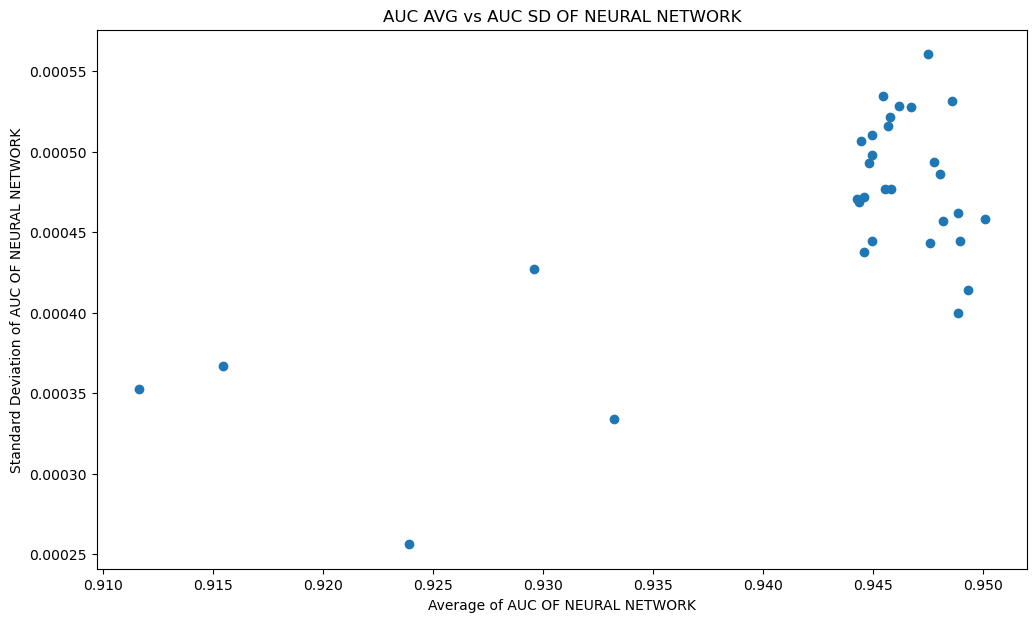

In [102]:
plt.figure(figsize=(12,7))
plt.scatter(Grid_Search_Results_nn['AUC AVG'], Grid_Search_Results_nn['AUC SD'])
xlab = 'Average of AUC OF NEURAL NETWORK'
ylab = 'Standard Deviation of AUC OF NEURAL NETWORK'
title = 'AUC AVG vs AUC SD OF NEURAL NETWORK'
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.show()

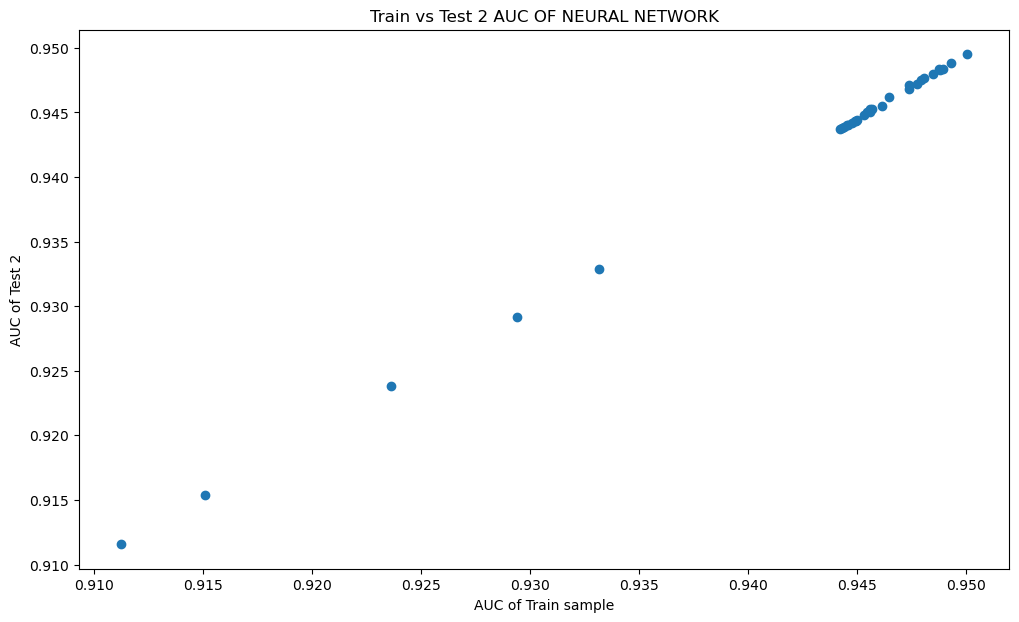

In [104]:
plt.figure(figsize=(12,7))
plt.scatter(Grid_Search_Results_nn['AUC Train'], Grid_Search_Results_nn['AUC Test 2'])
xlab = 'AUC of Train sample'
ylab = 'AUC of Test 2'
title = 'Train vs Test 2 AUC OF NEURAL NETWORK'
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(title)
plt.show()

In [105]:
# Step 15: Choose best Neural Network model
best_model_idx = Grid_Search_Results_nn[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1).idxmax()
best_params = Grid_Search_Results_nn.iloc[best_model_idx].to_dict()
best_params

{'HL': 4,
 'Nodes': 6,
 'Activation Function': 'tanh',
 'Dropout': 0,
 'Batch Size': 100,
 'AUC Train': 0.950057586787949,
 'AUC Test 1': 0.950629026669823,
 'AUC Test 2': 0.9495072408584444,
 'AUC AVG': 0.9500646181054054,
 'AUC SD': 0.00045799412748887534}

In [109]:
# Calculate the mean of AUC Test1 and AUC Test2
Grid_Search_Results_nn['Mean AUC Test'] = (Grid_Search_Results_nn['AUC Test 1'] + Grid_Search_Results_nn['AUC Test 2']) / 2

# Find the row with the highest mean AUC Test score
best_params = Grid_Search_Results_nn.loc[Grid_Search_Results_nn['Mean AUC Test'].idxmax()]

# Print the best model information
print("Best Model (based on Mean AUC Test):")
print(best_params)

Best Model (based on Mean AUC Test):
HL                            4
Nodes                         6
Activation Function        tanh
Dropout                       0
Batch Size                  100
AUC Train              0.950058
AUC Test 1             0.950629
AUC Test 2             0.949507
AUC AVG                0.950065
AUC SD                 0.000458
Mean AUC Test          0.950068
Name: 28, dtype: object


In [114]:
# hyperparameters of the best model
best_n_layers = int(best_params['HL'])
best_n_nodes = int(best_params['Nodes'])
best_activation = best_params['Activation Function']
best_dropout = float(best_params['Dropout']) / 100.0
best_batch_size = int(best_params['Batch Size'])

In [115]:
best_nn_model = Sequential()
best_nn_model.add(Dense(best_params['Nodes'], input_dim=X_train_nn.shape[1], activation=best_params['Activation Function']))
best_nn_model.add(Dropout(best_params['Dropout']))
for _ in range(best_params['HL'] - 1):
    best_nn_model.add(Dense(best_params['Nodes'], activation=best_params['Activation Function']))
    best_nn_model.add(Dropout(best_params['Dropout']))
best_nn_model.add(Dense(1, activation='sigmoid'))
best_nn_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
best_nn_model.fit(X_train_nn, Y_train, batch_size=best_params['Batch Size'], epochs=20, verbose=0)

C:\Users\yxb220022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [129]:
best_nn_model.save('best_nn_model.keras')

In [116]:
loss, accuracy = best_nn_model.evaluate(X_train_nn, Y_train, verbose=0)

In [117]:
accuracy

0.8960288166999817

In [81]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [82]:
from tensorflow.keras.models import load_model


In [83]:
model_path = 'best_nn_model (1).keras'
best_nn_model = load_model(model_path)

In [84]:
# Calculate AUC on each sample
y_train_pred = best_nn_model.predict(X_train)
y_test1_pred = best_nn_model.predict(X_test1)
y_test2_pred = best_nn_model.predict(X_test2)

24204/24204 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


24204/24204 ━━━━━━━━━━━━━━━━━━━━ 9s 377us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 379us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 370us/step
AUC on Train: 0.9492522529085873
AUC on Test 1: 0.9497996817435154
AUC on Test 2: 0.9486304625221781


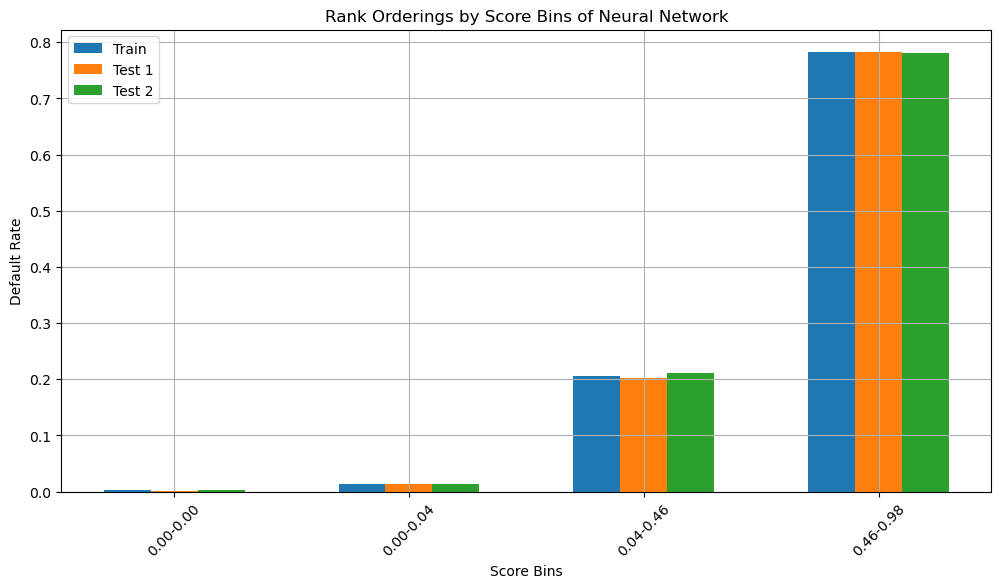

In [137]:

auc_train = roc_auc_score(Y_train, y_train_pred)
auc_test1 = roc_auc_score(Y_test1, y_test1_pred)
auc_test2 = roc_auc_score(Y_test2, y_test2_pred)

print(f"AUC on Train: {auc_train}")
print(f"AUC on Test 1: {auc_test1}")
print(f"AUC on Test 2: {auc_test2}")

# Define score bins based on the train sample
train_scores = y_train_pred.reshape(-1)
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Calculate the value ranges for each bin
bin_ranges = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

# Apply the same thresholds to test samples
test1_scores = y_test1_pred.reshape(-1)
test2_scores = y_test2_pred.reshape(-1)

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, Y_train)
default_rates_test1 = calculate_default_rate(test1_scores, Y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, Y_test2)

x_indexes = np.arange(len(bin_ranges))

plt.figure(figsize=(12, 6))
plt.bar(x_indexes - width, default_rates_train, width=width, label='Train', align='center')
plt.bar(x_indexes, default_rates_test1, width=width, label='Test 1', align='center')
plt.bar(x_indexes + width, default_rates_test2, width=width, label='Test 2', align='center')

plt.xlabel('Score Bins')
plt.ylabel('Default Rate')
plt.title('Rank Orderings by Score Bins of Neural Network')
plt.xticks(x_indexes, bin_ranges, rotation=45)  # Display bin ranges on the x-axis
plt.legend()
plt.grid(True)
plt.show()

In [124]:
best_params #for xgboost

{'Number Trees': 300,
 'Learning Rate': 0.1,
 'Subsample': 0.5,
 '% Features': 1.0,
 'Weight of Default': 1,
 'AUC Train': 0.9864363931223391,
 'AUC Test 1': 0.9844763299918364,
 'AUC Test 2': 0.9838279057300264,
 'AUC AVG': 0.9849135429480672,
 'AUC SD': 0.001108878711667981}

In [125]:
best_model_nn #for Neural Network

HL                            4
Nodes                         6
Activation Function        tanh
Dropout                       0
Batch Size                  100
AUC Train              0.950058
AUC Test 1             0.950629
AUC Test 2             0.949507
AUC AVG                0.950065
AUC SD                 0.000458
Mean AUC Test          0.950068
Name: 28, dtype: object

In [152]:
# AUC scores from best_model_row
auc_test1_xgb = best_params['AUC Test 1']
auc_test2_xgb = best_params['AUC Test 2']

# average AUC score for best_model_row
avg_auc_xgb = (auc_test1_xgb + auc_test2_xgb) / 2
print("Avg AUC value of XGB Model :",avg_auc_xgb)

# AUC scores from best_model_select
auc_test1_nn = best_model_nn['AUC Test 1']
auc_test2_nn = best_model_nn['AUC Test 2']

# average AUC score for best_model_select
avg_auc_nn = (auc_test1_nn + auc_test2_nn) / 2
print("Avg AUC value of NN Model :",avg_auc_nn)

# Determine the best model and label the AUC values
if avg_auc_xgb > avg_auc_nn:
    best_model = "XGB Model"  # XGBoost model is better
    best_avg_auc = avg_auc_xgb
    model_label = "Avg AUC value of "
else:
    best_model = "NN Model"  # Neural Network model is better
    best_avg_auc = avg_auc_nn
    model_label = "Avg AUC value of "


print(f"The best model is {best_model} with {model_label}: {best_avg_auc:.5f}")

Avg AUC value of XGB Model : 0.9841521178609314
Avg AUC value of NN Model : 0.9500681337641337
The best model is XGB Model with Avg AUC value of : 0.98415


In [153]:
auc_train_xgb = best_params['AUC Train']

In [154]:
auc_train_nn = best_model_nn['AUC Train']

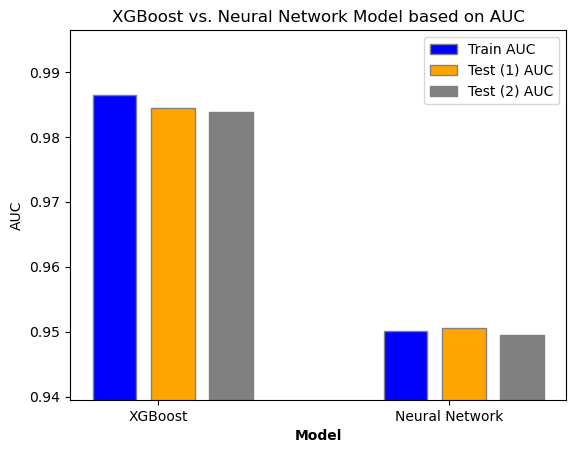

In [160]:
import matplotlib.pyplot as plt
 
# Data for plotting
models = ['XGBoost', 'Neural Network']
train_auc = [auc_train_xgb, auc_train_nn]  # Placeholder values
test1_auc = [auc_test1_xgb, auc_test1_nn]  # Placeholder values
test2_auc = [auc_test2_xgb, auc_test2_nn]  # Placeholder values
 
# Set up the bar width and positions
barWidth = 0.15
# r1 = [1, 2]
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

r1 = np.arange(len(train_auc))
r2 = [x + barWidth + 0.05 for x in r1]
r3 = [x + barWidth + 0.05 for x in r2]
 
# Create the bars
plt.bar(r1, train_auc, color='blue', width=barWidth, edgecolor='grey', label='Train AUC')
plt.bar(r2, test1_auc, color='orange', width=barWidth, edgecolor='grey', label='Test (1) AUC')
plt.bar(r3, test2_auc, color='grey', width=barWidth, edgecolor='grey', label='Test (2) AUC')
 
# Add labels and title
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train_auc))], models)
plt.ylabel('AUC')
plt.title('XGBoost vs. Neural Network Model based on AUC')

plt.ylim(min(train_auc + test1_auc + test2_auc) - 0.01, max(train_auc + test1_auc + test2_auc) + 0.01)
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [115]:
# Step 16: Choose final model
# Since the AUC values for all 3 - X_Train, X_Test1 and X_Test2 is more in the XGBoost model than the 
# NN model and the bias variance is also lesser, we choose XGBoost Model.

In [116]:
# Step 17: Strategy function
def calculate_strategy_performance(data, target_col, model_output_col, balance_col, spend_col, threshold):
    accepted = data[data[model_output_col] < threshold]
    rejected = data[data[model_output_col] >= threshold]
    
    portfolio_default_rate = accepted[target_col].mean()
    
    accepted_defaulters = accepted[accepted[target_col] == 1]
    accepted_non_defaulters = accepted[accepted[target_col] == 0]
    
    defaulter_revenue = 0
    non_defaulter_revenue = accepted_non_defaulters[balance_col].mean() * 0.02 + accepted_non_defaulters[spend_col].mean() * 0.001
    non_defaulter_revenue *= 12  # For 12 months
    
    portfolio_revenue = non_defaulter_revenue * len(accepted_non_defaulters)
    
    return portfolio_default_rate, portfolio_revenue

Stratergy

In [163]:

# X = df_new_all.drop(['target','S_2','customer_ID'], axis=1)
# Y = df_new_all['target']

# # Splitting into 70% training and 30% testing
# X_train, X_test_combined, Y_train, y_test_combined = train_test_split(X, Y, test_size=0.3, random_state=42)

# # Splitting the combined test set into two equal parts
# X_test1, X_test2, Y_test1, Y_test2 = train_test_split(X_test_combined, y_test_combined, test_size=0.5, random_state=42)

In [27]:
X_train.columns

Index(['P_2_Last6_mean', 'R_1_Last6_mean', 'B_11_Last6_mean', 'B_7_Last6_mean',
       'B_1_Last6_mean', 'B_2_Last6_mean', 'R_2_Last6_mean', 'B_22_Last6_mean',
       'S_3_Last6_mean', 'D_65_Last6_mean', 'D_45_Last6_mean',
       'D_50_Last6_mean', 'B_4_Last6_mean', 'D_49_Last6_mean',
       'S_3_Last12_mean', 'S_25_Last6_mean', 'B_5_Last6_mean',
       'B_18_Last6_mean', 'B_33_Last6_mean', 'D_44_Last6_mean',
       'B_23_Last6_mean', 'B_22_Last12_mean', 'D_44_Last12_mean',
       'B_26_Last6_mean', 'B_29', 'D_49_Last12_mean', 'D_56',
       'D_50_Last12_mean', 'D_43_Last12_mean', 'D_45_Last12_mean',
       'D_42_Last12_mean', 'D_66_1.0_ever_response_12', 'S_25_Last12_mean'],
      dtype='object')

In [23]:
import xgboost as xgb

# Load the model from the file
best_xgb_model = xgb.XGBClassifier()
best_xgb_model.load_model('best_xgb_model (1).json')

# Now 'loaded_model' is ready to be used for predictions


In [24]:
best_xgb_model

XGBClassifier(base_score='2.6976192E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'fl...
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### STRATERGY

In [49]:
# # Get predictions for the train dataset
# xgb_predictions_train = best_xgb_model.predict(X_train)

# # Get predictions for the test1 dataset
# xgb_predictions_test1 = best_xgb_model.predict(X_test1)

# # Get predictions for the test2 dataset
# xgb_predictions_test2 = best_xgb_model.predict(X_test2)

# Get predicted probabilities for the train dataset
xgb_probs_train = best_xgb_model.predict_proba(X_train)

# Get predicted probabilities for the test1 dataset
xgb_probs_test1 = best_xgb_model.predict_proba(X_test1)

# Get predicted probabilities for the test2 dataset
xgb_probs_test2 = best_xgb_model.predict_proba(X_test2)

In [46]:

# Define the thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize lists to store default rates, portfolio revenues, and the number of applicants for the training data
default_rates_train = []
portfolio_revenues_train = []
applicant_counts_train = []

# Choose your desired spend and balance features for the training data
spend_feature_train = X_train['S_3_Last6_mean']
balance_feature_train = X_train['B_29']

df_new_all['S_2']= pd.to_datetime(df_new_all['S_2'])
# Get the date feature "S_2" from df_new_all
date_feature_train = df_new_all['S_2']

# Calculate the average spend and balance for the last 6 months i.e. November 2017 to April 2018 for the training data
start_date = pd.to_datetime("2017-11-01")
end_date = pd.to_datetime("2018-04-30")
filtered_data_train = X_train[(date_feature_train >= start_date) & (date_feature_train <= end_date)]
average_spend_train = np.mean(filtered_data_train['S_3_Last6_mean'])
average_balance_train = np.mean(filtered_data_train['B_29'])

# Calculate the monthly revenue for 1 customer for the training data
monthly_revenue_train = average_balance_train * 0.02 + average_spend_train * 0.001

# Calculate the expected annual revenue for the training data over the next 12 months
expected_revenue_train = monthly_revenue_train * 12

for threshold in thresholds:
    # Filter applicants based on the threshold for the training data
    accepted_indices_train = xgb_probs_train[:, 1] < threshold  # Results in the true and False list format
    total_applicants_train = len(accepted_indices_train) #Trained data length

    # Calculate the number of applicants who defaulted for the training data
    defaulted_applicants_train = np.sum(Y_train[accepted_indices_train])
    default_rate_train = defaulted_applicants_train / total_applicants_train # Calculate the default rate among all applicants for the training data
    portfolio_revenue_value_train = np.sum(expected_revenue_train * accepted_indices_train)

    default_rates_train.append(default_rate_train)
    portfolio_revenues_train.append(portfolio_revenue_value_train)
    applicant_counts_train.append(total_applicants_train)

# Print the results for each threshold for the training data
for i, threshold in enumerate(thresholds):
    print(f"Training Data -> Threshold: {threshold:.1f}, Default Rate: {default_rates_train[i]}, Portfolio Revenue: ${portfolio_revenues_train[i]:.2f}, Number of Applicants: {applicant_counts_train[i]}\n")

C:\Users\dbavi\AppData\Local\Temp\ipykernel_4632\1181344115.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data_train = X_train[(date_feature_train >= start_date) & (date_feature_train <= end_date)]


Training Data -> Threshold: 0.1, Default Rate: target    0.001371
dtype: float64, Portfolio Revenue: $5167.45, Number of Applicants: 774503

Training Data -> Threshold: 0.2, Default Rate: target    0.00439
dtype: float64, Portfolio Revenue: $5615.09, Number of Applicants: 774503

Training Data -> Threshold: 0.3, Default Rate: target    0.009495
dtype: float64, Portfolio Revenue: $5905.98, Number of Applicants: 774503

Training Data -> Threshold: 0.4, Default Rate: target    0.017148
dtype: float64, Portfolio Revenue: $6155.13, Number of Applicants: 774503

Training Data -> Threshold: 0.5, Default Rate: target    0.028139
dtype: float64, Portfolio Revenue: $6388.93, Number of Applicants: 774503

Training Data -> Threshold: 0.6, Default Rate: target    0.044532
dtype: float64, Portfolio Revenue: $6632.29, Number of Applicants: 774503

Training Data -> Threshold: 0.7, Default Rate: target    0.067943
dtype: float64, Portfolio Revenue: $6902.07, Number of Applicants: 774503

Training Data 

In [69]:
average_spend_train

0.2266632397550913

In [70]:
average_balance_train

0.03450789127256344

In [78]:
accepted_indices_train = xgb_probs_train[:, 1] < 0.5
total_applicants_train = len(accepted_indices_train)
defaulted_applicants_train = np.sum(Y_train[accepted_indices_train])
defaulted_applicants_train
default_rate_train = defaulted_applicants_train / total_applicants_train
default_rate_train
portfolio_revenue_value_train = np.sum(expected_revenue_train * accepted_indices_train)
portfolio_revenue_value_train

6388.92993672296

In [66]:

# Define the thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize lists to store default rates, portfolio revenues, and the number of applicants for the training data
default_rates_test1 = []
portfolio_revenues_test1 = []
applicant_counts_test1 = []

# Choose your desired spend and balance features for the training data
spend_feature_train = X_test1['S_3_Last6_mean']
balance_feature_train = X_test1['B_29']

df_new_all['S_2']= pd.to_datetime(df_new_all['S_2'])
# Get the date feature "S_2" from df_new_all
date_feature_train = df_new_all['S_2']

# Calculate the average spend and balance for the last 6 months (November 2017 to April 2018) for the training data
start_date = pd.to_datetime("2017-11-01")
end_date = pd.to_datetime("2018-04-30")
filtered_data_test1 = X_train[(date_feature_train >= start_date) & (date_feature_train <= end_date)]
average_spend_test1 = np.mean(filtered_data_train['S_3_Last6_mean'])
average_balance_test1 = np.mean(filtered_data_train['B_29'])

# Calculate the monthly revenue for 1 customer for the training data
monthly_revenue_test1 = average_balance_test1 * 0.02 + average_spend_test1 * 0.001

# Calculate the expected annual revenue for the training data over the next 12 months
expected_revenue_test1 = monthly_revenue_test1 * 12

for threshold in thresholds:
    accepted_indices_test1 = xgb_probs_test1[:, 1] < threshold  # True for accepted, False for rejected
    total_applicants_test1 = len(accepted_indices_test1)# Calculate the number of all applicants for the training data

    # Calculate the number of applicants who defaulted for the training data
    defaulted_applicants_test1 = np.sum(Y_test1[accepted_indices_test1])

    # Calculate the default rate among all applicants for the training data
    default_rate_test1 = defaulted_applicants_test1 / total_applicants_test1

    # Calculate the portfolio revenue for the training data
    portfolio_revenue_value_test1 = np.sum(expected_revenue_test1 * accepted_indices_test1)

    # Append results to the lists for the training data
    default_rates_test1.append(default_rate_test1)
    portfolio_revenues_test1.append(portfolio_revenue_value_test1)
    applicant_counts_test1.append(total_applicants_test1)

# Print the results for each threshold for the training data
for i, threshold in enumerate(thresholds):
    print(f"Test_1 Data -> Threshold: {threshold:.1f}, Default Rate: {default_rates_test1[i]}, Portfolio Revenue: ${portfolio_revenues_test1[i]:.2f}, Number of Applicants: {applicant_counts_test1[i]}\n")

Test_1 Data -> Threshold: 0.1, Default Rate: target    0.001784
dtype: float64, Portfolio Revenue: $1105.04, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.2, Default Rate: target    0.00514
dtype: float64, Portfolio Revenue: $1200.05, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.3, Default Rate: target    0.010641
dtype: float64, Portfolio Revenue: $1262.75, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.4, Default Rate: target    0.018787
dtype: float64, Portfolio Revenue: $1317.42, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.5, Default Rate: target    0.029711
dtype: float64, Portfolio Revenue: $1367.18, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.6, Default Rate: target    0.046293
dtype: float64, Portfolio Revenue: $1420.33, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.7, Default Rate: target    0.069424
dtype: float64, Portfolio Revenue: $1478.49, Number of Applicants: 165965

Test_1 Data -> Threshold: 0.

C:\Users\dbavi\AppData\Local\Temp\ipykernel_4632\3053918207.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data_test1 = X_train[(date_feature_train >= start_date) & (date_feature_train <= end_date)]


In [67]:

# Define the thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize lists to store default rates, portfolio revenues, and the number of applicants for the test_2 data
default_rates_test2 = []
portfolio_revenues_test2 = []
applicant_counts_test2 = []

# Choose your desired spend and balance features for the test_2 data
spend_feature_test2 = X_test2['S_3_Last6_mean']
balance_feature_test2 = X_test2['B_29']

df_new_all['S_2']= pd.to_datetime(df_new_all['S_2'])

# Get the date feature "S_2" from df_new_all
date_feature_test2 = df_new_all['S_2']

# Calculate the average spend and balance for the last 6 months (November 2017 to April 2018) for the test_2 data
start_date = pd.to_datetime("2017-11-01")
end_date = pd.to_datetime("2018-04-30")
filtered_data_test2 = X_test2[(date_feature_test2 >= start_date) & (date_feature_test2 <= end_date)]
average_spend_test2 = np.mean(filtered_data_test2['S_3_Last6_mean'])
average_balance_test2 = np.mean(filtered_data_test2['B_29'])

# Calculate the monthly revenue for 1 customer for the test_2 data
monthly_revenue_test2 = average_balance_test2 * 0.02 + average_spend_test2 * 0.001

# Calculate the expected annual revenue for the test_2 data over the next 12 months
expected_revenue_test2 = monthly_revenue_test2 * 12

# Iterate through the thresholds for the test_2 data
for threshold in thresholds:
    accepted_indices_test2 = xgb_probs_test2[:, 1] < threshold  # True for accepted, False for rejected
    total_applicants_test2 = len(accepted_indices_test2) # Calculate the number of all applicants for the test_2 data
    defaulted_applicants_test2 = np.sum(Y_test2[accepted_indices_test2])# Calculate the number of applicants who defaulted for the test_2 data

    # Calculate the default rate among all applicants for the test_2 data
    default_rate_test2 = defaulted_applicants_test2 / total_applicants_test2

    # Calculate the portfolio revenue for the test_2 data
    portfolio_revenue_value_test2 = np.sum(expected_revenue_test2 * accepted_indices_test2)
    default_rates_test2.append(default_rate_test2)
    portfolio_revenues_test2.append(portfolio_revenue_value_test2)
    applicant_counts_test2.append(total_applicants_test2)

# Print the results for each threshold for the test_2 data
for i, threshold in enumerate(thresholds):
    print(f"Test_2 Data - Threshold: {threshold:.1f}, Default Rate: {default_rates_test2[i]}, Portfolio Revenue: ${portfolio_revenues_test2[i]:.2f}, Number of Applicants: {applicant_counts_test2[i]}\n")

Test_2 Data - Threshold: 0.1, Default Rate: target    0.002067
dtype: float64, Portfolio Revenue: $1004.64, Number of Applicants: 165966

Test_2 Data - Threshold: 0.2, Default Rate: target    0.005784
dtype: float64, Portfolio Revenue: $1090.41, Number of Applicants: 165966

Test_2 Data - Threshold: 0.3, Default Rate: target    0.011701
dtype: float64, Portfolio Revenue: $1147.34, Number of Applicants: 165966

Test_2 Data - Threshold: 0.4, Default Rate: target    0.019823
dtype: float64, Portfolio Revenue: $1196.64, Number of Applicants: 165966

Test_2 Data - Threshold: 0.5, Default Rate: target    0.03147
dtype: float64, Portfolio Revenue: $1242.94, Number of Applicants: 165966

Test_2 Data - Threshold: 0.6, Default Rate: target    0.048179
dtype: float64, Portfolio Revenue: $1291.07, Number of Applicants: 165966

Test_2 Data - Threshold: 0.7, Default Rate: target    0.071424
dtype: float64, Portfolio Revenue: $1343.93, Number of Applicants: 165966

Test_2 Data - Threshold: 0.8, Defau

C:\Users\dbavi\AppData\Local\Temp\ipykernel_4632\1165220417.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data_test2 = X_test2[(date_feature_test2 >= start_date) & (date_feature_test2 <= end_date)]
